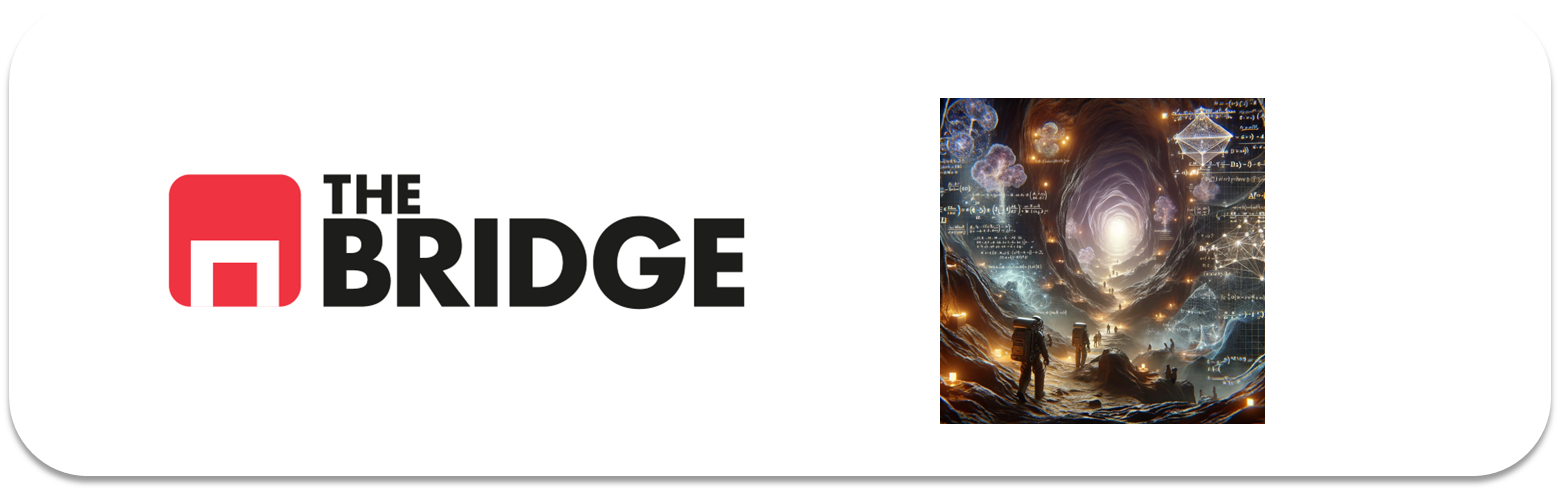

## PRACTICA OBLIGATORIA: **Introducción Deep Learning**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de modelado del dataset del titanic empleando y comparando dos modelos diferentes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import viztools as viz

---
---
### Descripción y objetivo

El objetivo de la práctica es crear un modelo DL y compararlo con un modelo Random Forest para el dataset de titanic los dos con el mismo objetivo, predecir la supervivencia de un pasajero.  Se pide:  
1. Desarrollar el proceso de ML hasta crear los dos modelos DL y Random Forest. El primero debe tener una topología MLP (es decir una red densa) con un máximo de 3 capas ocultas y debes emplear sklearn para crearlo. No es necesario hacer una análisis/seleccion exahustivo. Escoge una métrica acorde al tipo de target del problema. 

2. Ambos modelos deben tener sus hiperparámetros optimizados, mediante GridSearch. Para ello: utiliza el grid de parámetros que creas conveniente para Random Forest y para el modelo DL, utiliza un grid con los hiperparámetros siguientes:'hidden_layer_sizes','activation', 'solver','alpha' y 'learning_rate'. Para los rangos del grid del modelo de DL guíate por lo visto en el workout y por los posibles valores que se indican en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Prueba por lo menos una topología con una sola capa oculta y otra con más de una capa oculta.   
NOTA: Incluye los valores por defecto de los hiperparámetros escogidos en cada caso dentro del grid de hiperparámetros. 
  

3. Compara los modelos respecto a sus métricas medias de accuracy, precision, recall y tiempos de entrenamiento (para ello tendrás que realizar un entrenamiento a parte del mejor modelo obtenido en la optimización de hiperparámetros) y decide cuál te quedarías argumentándolo.    

4. Para el mejor modelo DL obtenido, muestra su clasification report, y la matriz de confusión comentando el resultado.
---
---

### 1. Load titanic and Initial Views

In [2]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True

In [ ]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


- can drop some columns that are doubled up already
    - alive: this is survived
    - class: this is pclass
    - embark_town: this is embarked
    - deck: can't remember what this was so going to drop for this exercise

In [4]:
titanic.drop(['alive','class','embark_town','deck'], axis=1, inplace=True)

In [5]:
titanic.head()

survived  pclass     sex   age  sibsp  parch     fare embarked    who  \
0         0       3    male  22.0      1      0   7.2500        S    man   
1         1       1  female  38.0      1      0  71.2833        C  woman   
2         1       3  female  26.0      0      0   7.9250        S  woman   
3         1       1  female  35.0      1      0  53.1000        S  woman   
4         0       3    male  35.0      0      0   8.0500        S    man   

   adult_male  alone  
0        True  False  
1       False  False  
2       False   True  
3       False  False  
4        True   True

In [6]:
titanic.isna().sum()

survived        0
pclass          0
sex             0
age           177
sibsp           0
parch           0
fare            0
embarked        2
who             0
adult_male      0
alone           0
dtype: int64

In [7]:
titanic.duplicated().sum()

111

- some NaNs to sort out
- drop all duplicates now before split

In [8]:
titanic.drop_duplicates(keep='first', inplace=True)
titanic.duplicated().sum()

0

Define target now as we know that is going to be 'survived'

In [9]:
target = 'survived'

---
---
### 2. Train/Test Split & Deal with Missing Values

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(titanic, test_size=0.2, stratify=titanic[target], random_state=42)

1. Check the missings and fill for train_set

In [11]:
train_set.isna().sum()

survived       0
pclass         0
sex            0
age           83
sibsp          0
parch          0
fare           0
embarked       2
who            0
adult_male     0
alone          0
dtype: int64

a) deal with embarked missings
- going to fill with mode

In [12]:
embarkedMode = train_set.embarked.mode()[0]
train_set['embarked'].fillna(embarkedMode, inplace=True)

In [13]:
train_set.isna().sum()

survived       0
pclass         0
sex            0
age           83
sibsp          0
parch          0
fare           0
embarked       0
who            0
adult_male     0
alone          0
dtype: int64

b) deal with age missings
- going to fill with means for who = man, woman, child

In [14]:
train_set['who'].value_counts()

man      355
woman    197
child     72
Name: who, dtype: int64

In [15]:
# Masks for men, women, children
men = train_set['who'] == 'man'
women = train_set['who'] == 'woman'
children = train_set['who'] == 'child'

# Mask for age isna
ageNaN = train_set['age'].isna()

# Use masks to get the means of men, women, children
meanMen = train_set.loc[men,'age'].mean()
meanWomen = train_set.loc[women,'age'].mean()
meanChildren = train_set.loc[children,'age'].mean()

# Impute the means for each group
train_set.loc[men & ageNaN, 'age'] = meanMen
train_set.loc[women & ageNaN, 'age'] = meanWomen
train_set.loc[children & ageNaN, 'age'] = meanChildren

- Repeat for test set so i know it's been taken care of
- Don't need to do missings for embarked as both missings in train set

In [16]:
# Masks for men, women, children
men = test_set['who'] == 'man'
women = test_set['who'] == 'woman'
children = test_set['who'] == 'child'

# Mask for age isna
ageNaN = test_set['age'].isna()

# Use masks to get the means of men, women, children
meanMen = test_set.loc[men,'age'].mean()
meanWomen = test_set.loc[women,'age'].mean()
meanChildren = test_set.loc[children,'age'].mean()

# Impute the means for each group
test_set.loc[men & ageNaN, 'age'] = meanMen
test_set.loc[women & ageNaN, 'age'] = meanWomen
test_set.loc[children & ageNaN, 'age'] = meanChildren

Recheck all missings

In [17]:
train_set.isna().sum()

survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
who           0
adult_male    0
alone         0
dtype: int64

---
---
### 3. Mini EDA

In [18]:
train_set.head()

survived  pclass     sex   age  sibsp  parch     fare embarked    who  \
710         1       1  female  24.0      0      0  49.5042        C  woman   
830         1       3  female  15.0      1      0  14.4542        C  child   
114         0       3  female  17.0      0      0  14.4583        C  woman   
652         0       3    male  21.0      0      0   8.4333        S    man   
624         0       3    male  21.0      0      0  16.1000        S    man   

     adult_male  alone  
710       False   True  
830       False  False  
114       False   True  
652        True   True  
624        True   True

**Initial Ideas:**
- already encoded
    - `pclass`

- Need encoding:
    - sex, embarked, who (label_encoder())
    - adult_male, alone (astype('int'))

- Look into sibsp and parch. Maybe combine into totalFamily

- Only really got age and fare as numeric features.

**Plan of Analyis:**
1. [X] Target distribution
2. [X] `sibsp` & `parch` distributions and relationship with target
3. [X] Feature engineer       
4. [X] Check all catFeatures for relationship with target `survived` 
    - viz.categorical_relationships()
    - mutual_info_score()
5. [X] Check numFeatures for relationship with target            
    - viz.plotAll4()
        - histplot
        - boxplot
        - combined histgrams
        - combined boxplots
6. [X] Check for colinearity                       
    - threshold testing
    [-] - Investigate using phik for heatmap correlations      

**EDA output:**
- [X] 2 feature sets:
    - bestSet
    - possibly

In [19]:
bestSet = []
possibly = []

1. Check target distribution

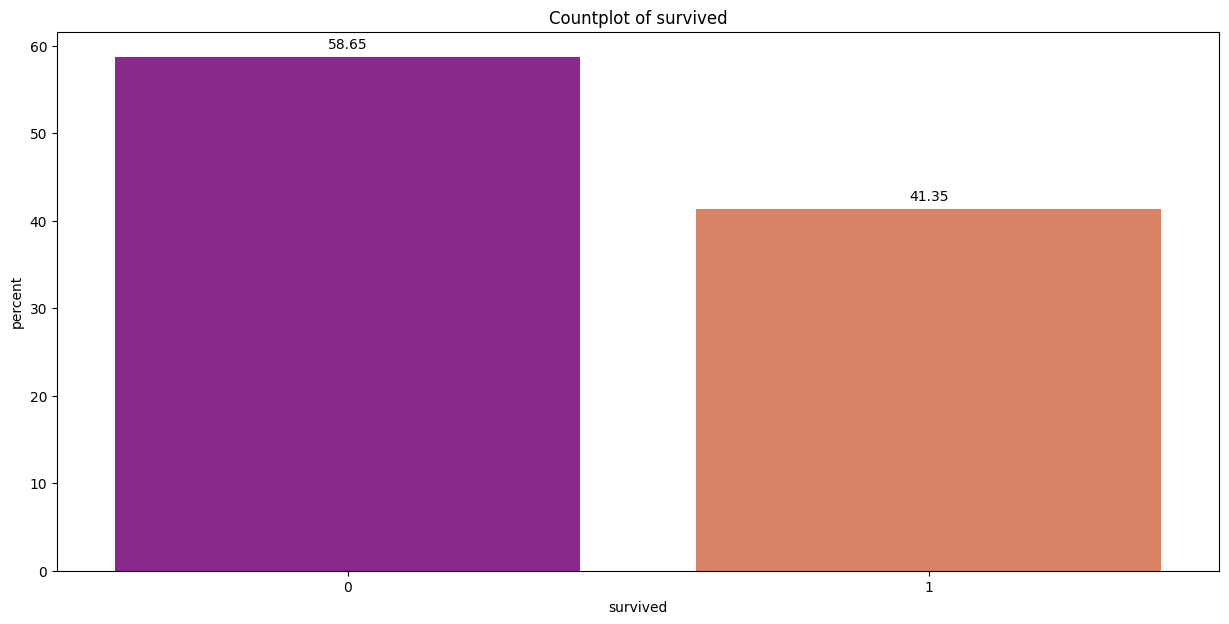

In [ ]:
viz.countplot(train_set, cat_col=target, show_vals=True, stat='percent')

Little bit unbalanced buuuuuut pa'lante

---

2. Check `sibsp` and `parch`

`sibsp`

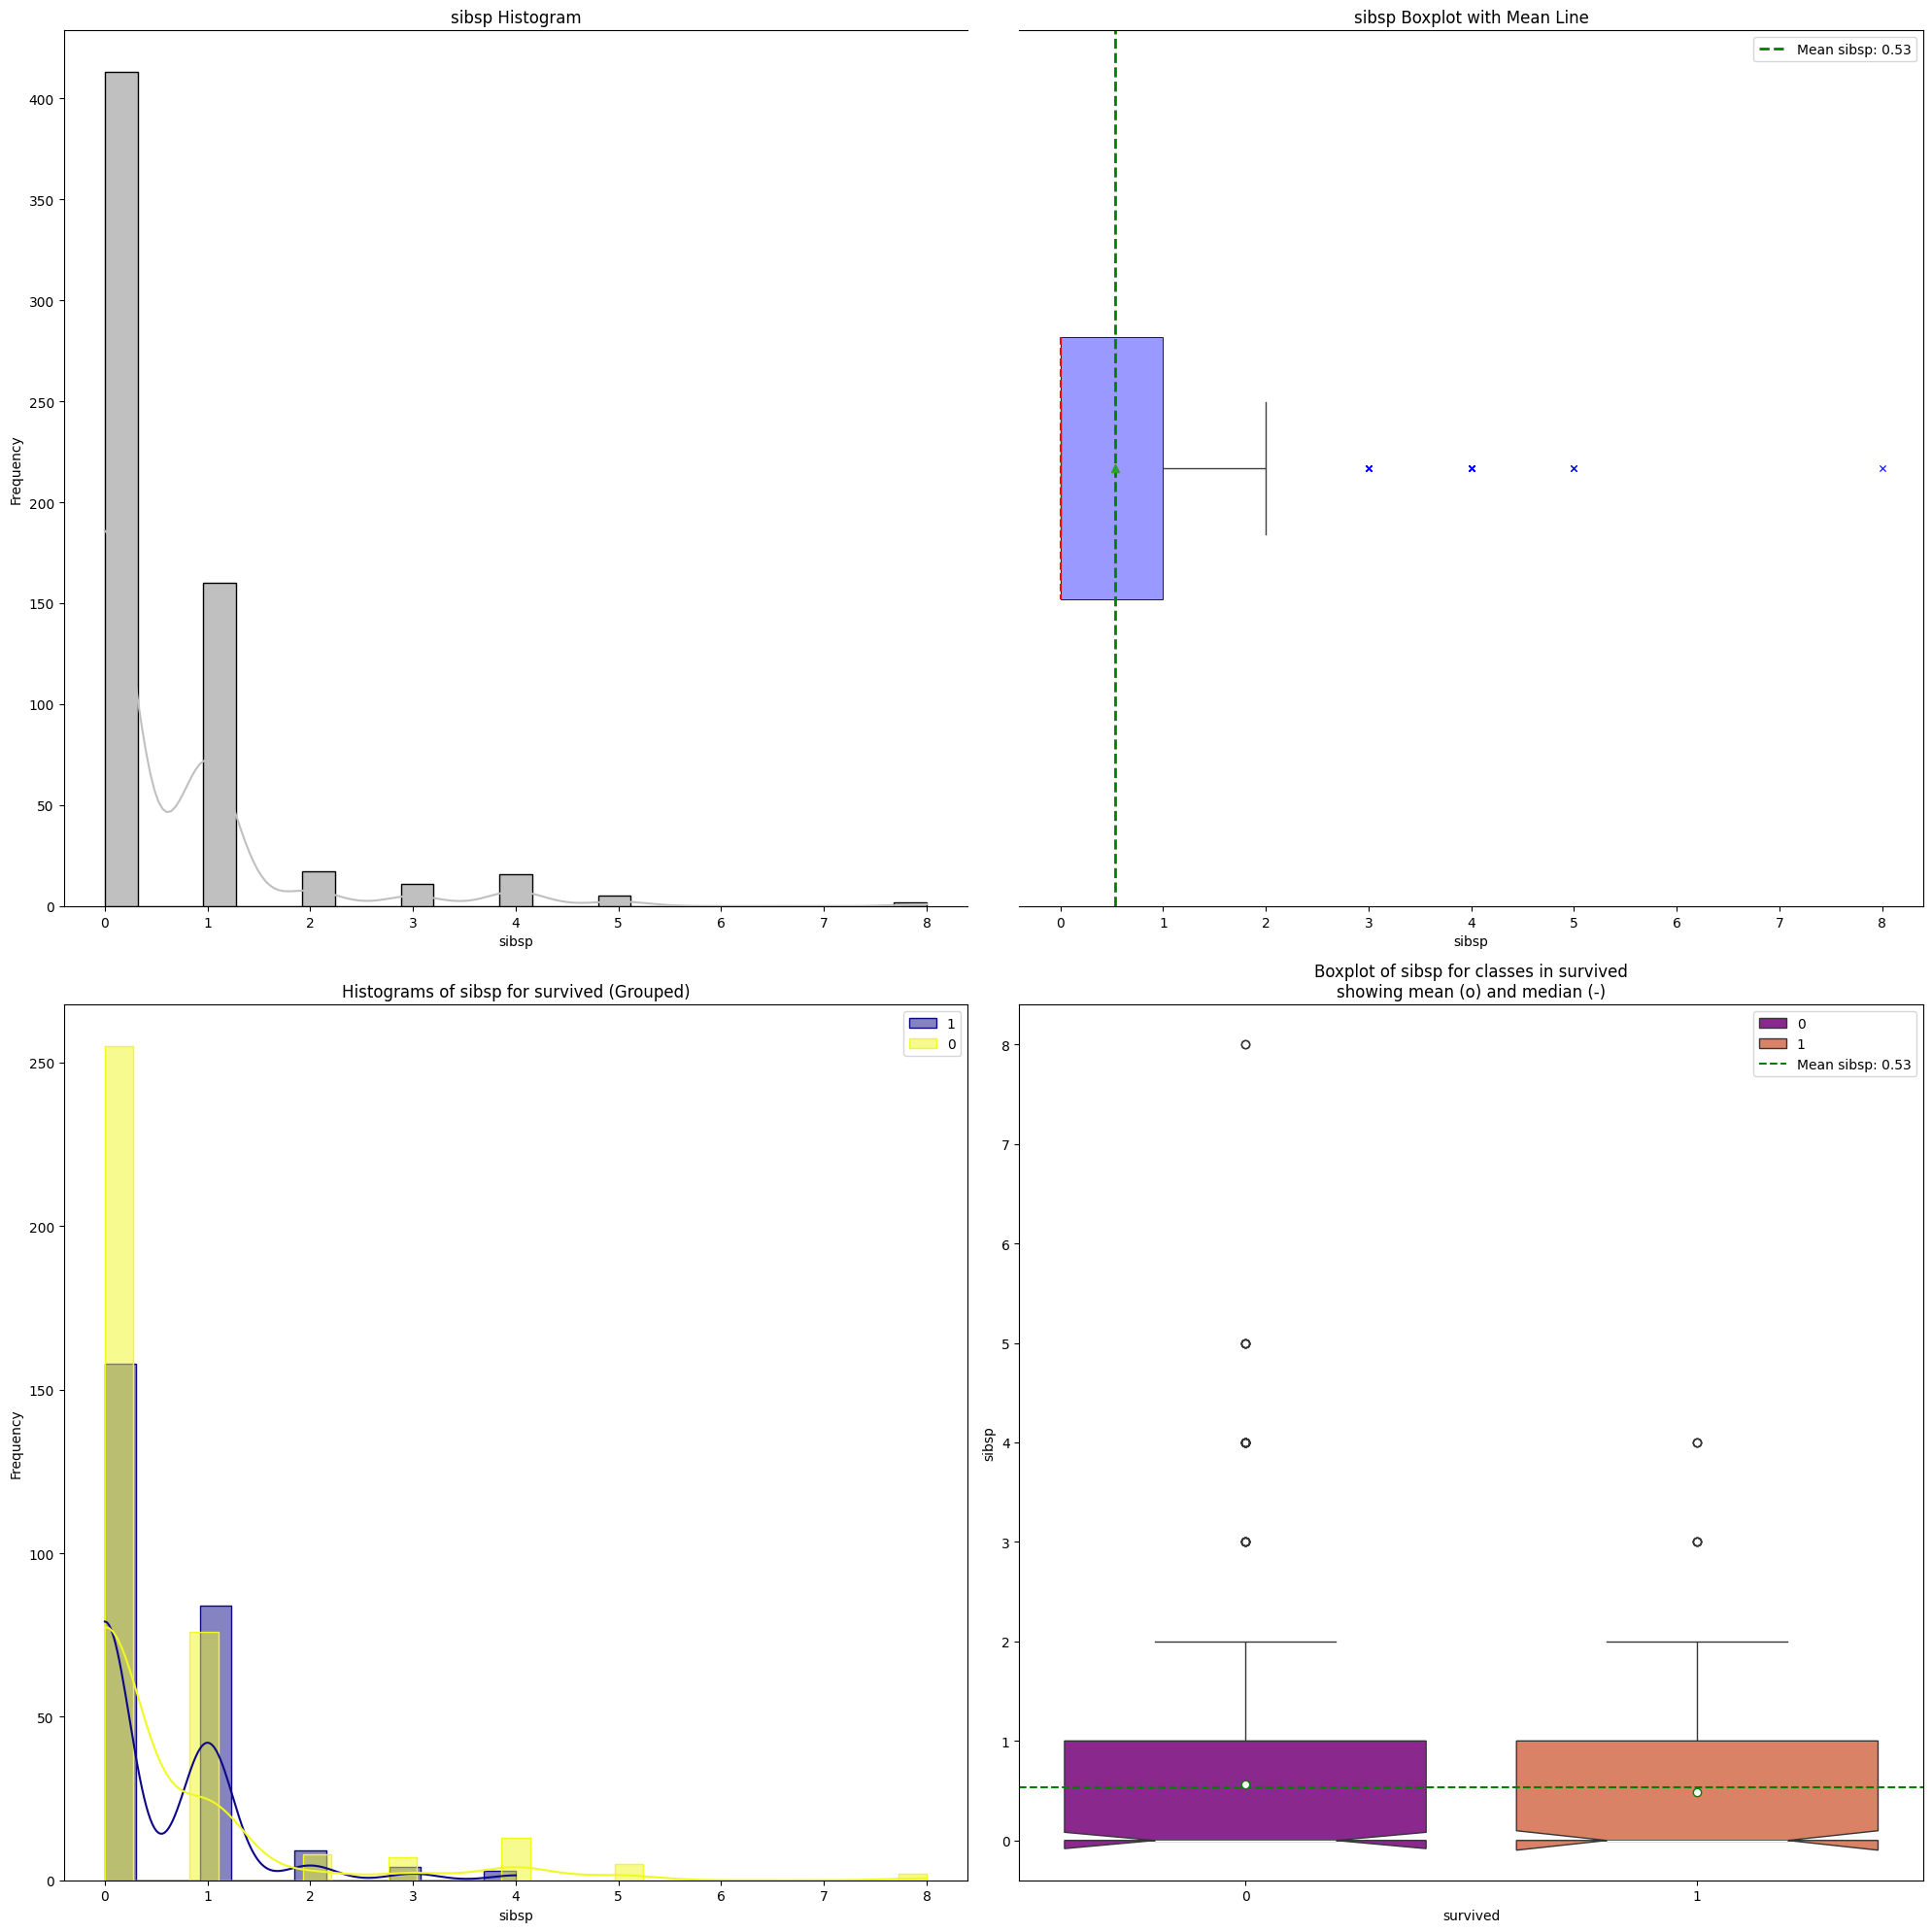

In [21]:
viz.plotAll4(train_set, cat_col=target, num_col='sibsp', show_mean=True, kde=True)

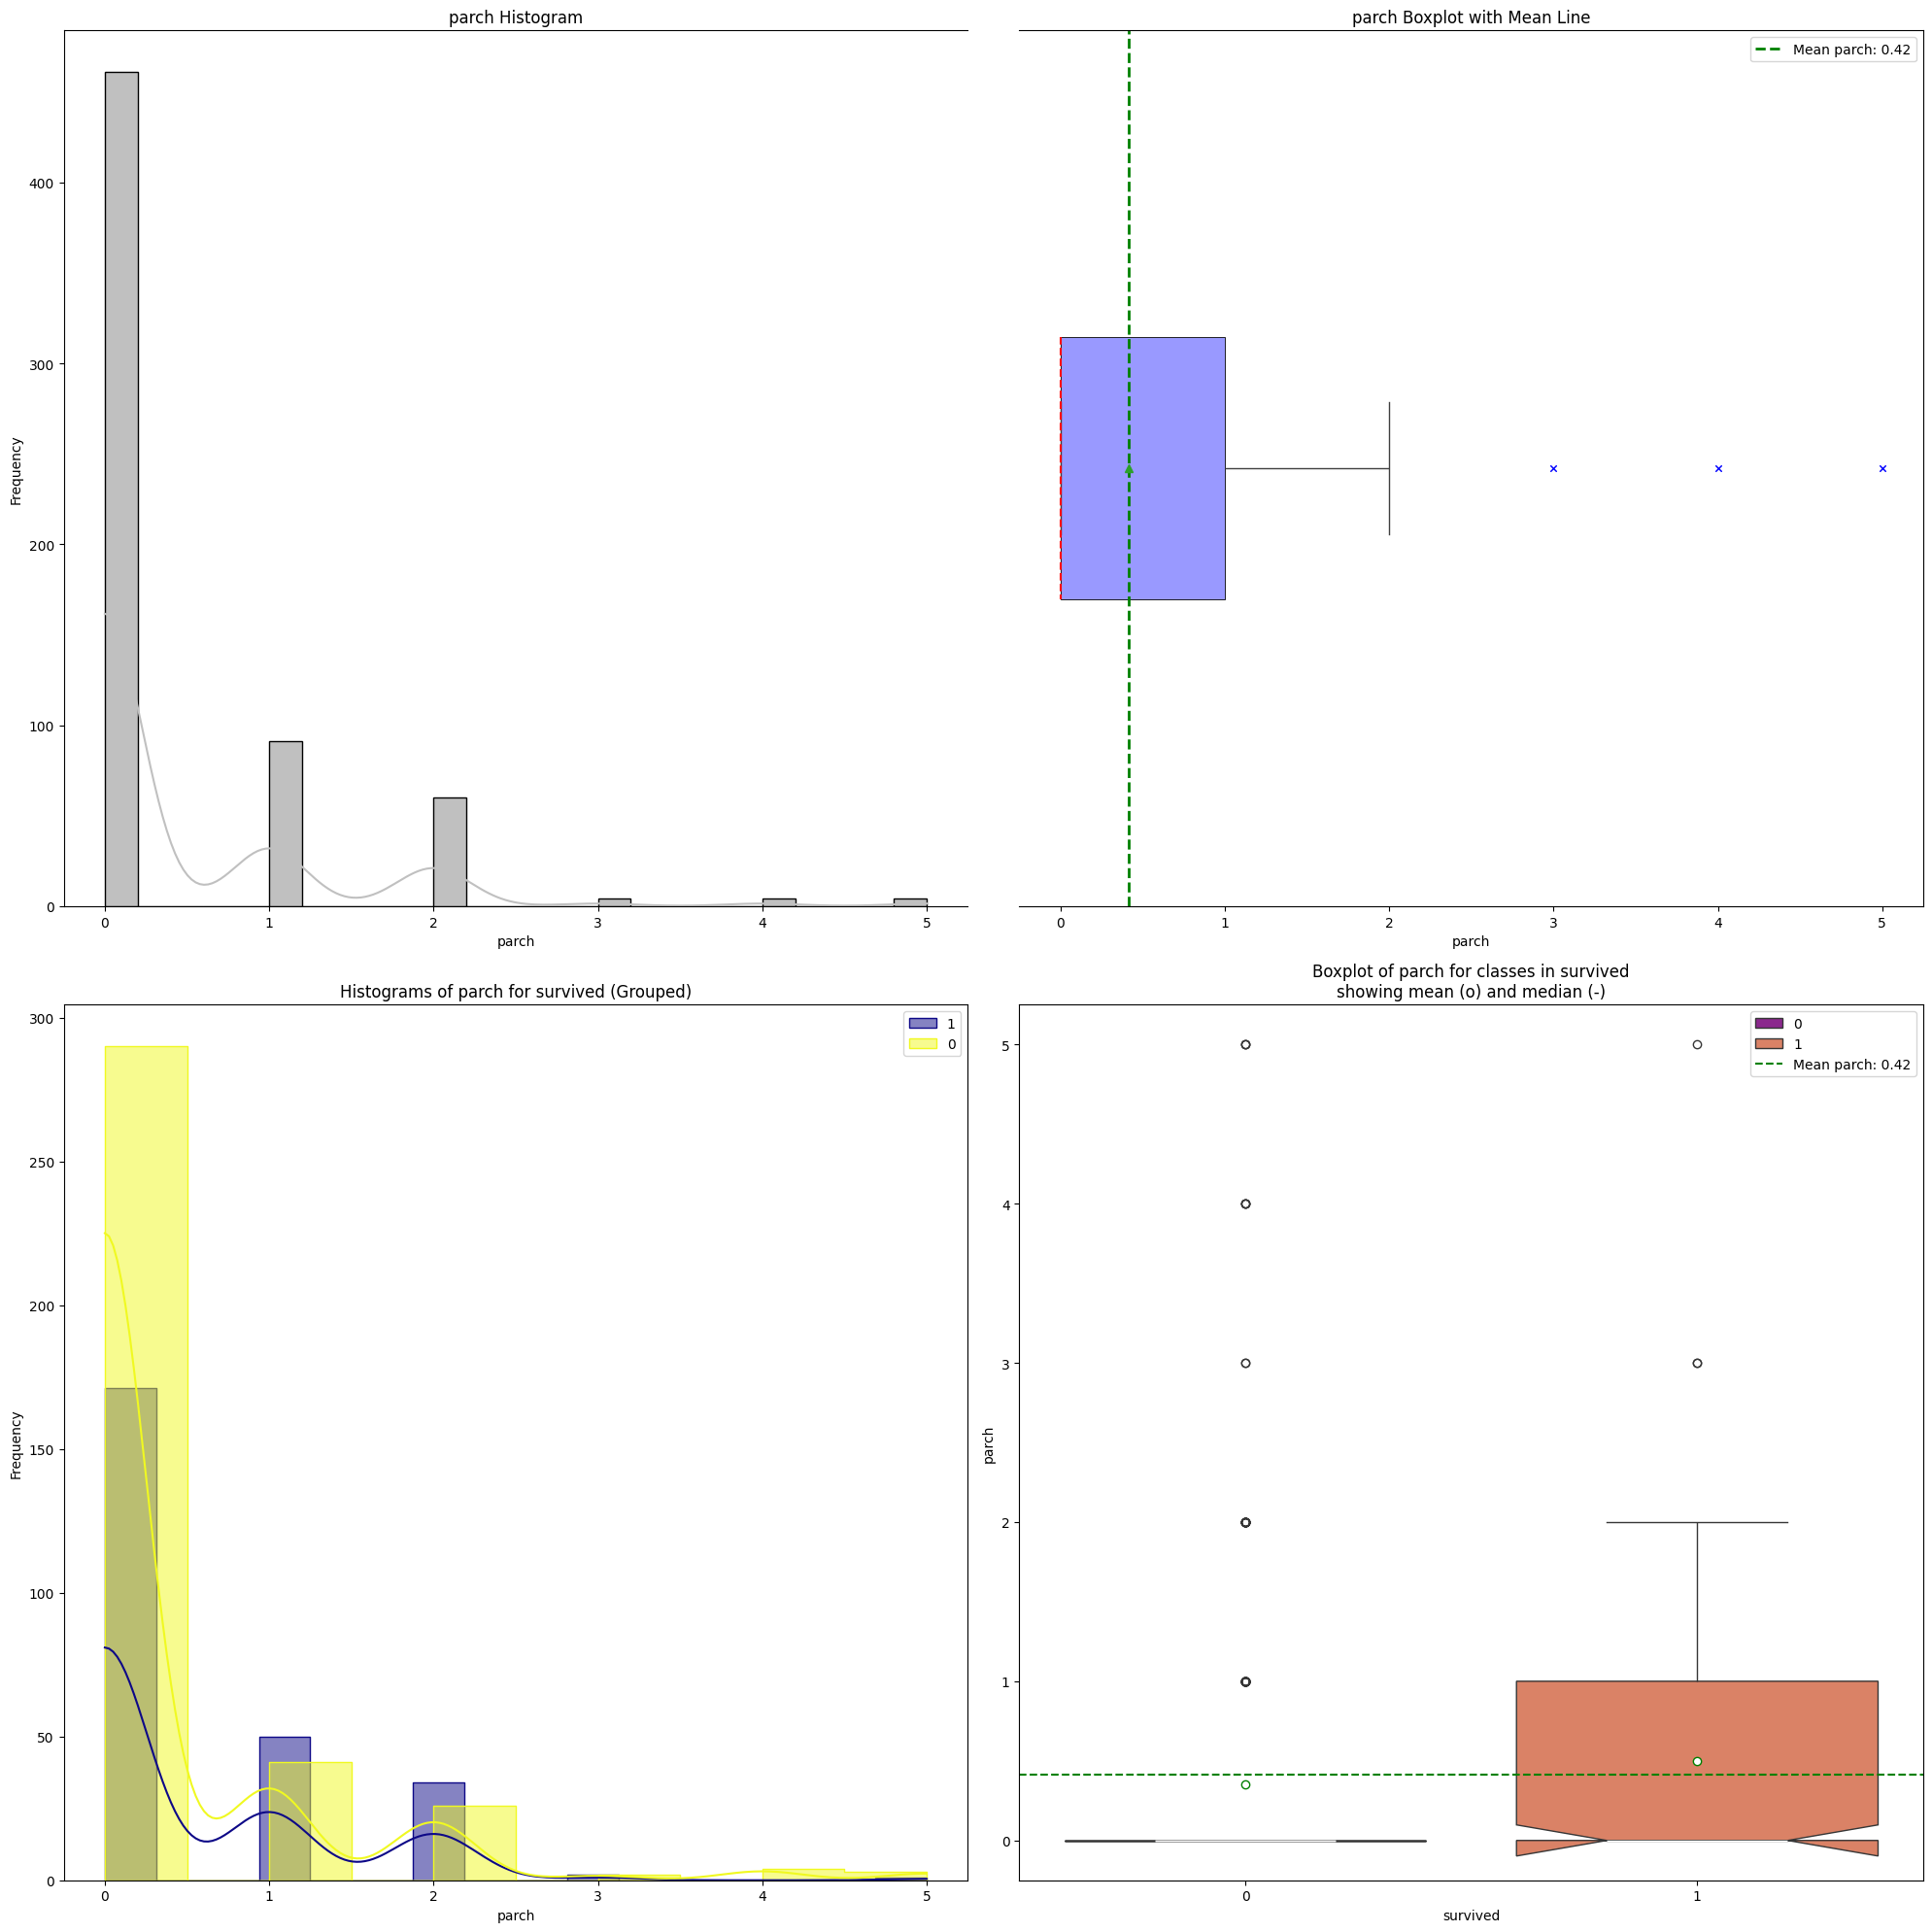

In [22]:
viz.plotAll4(train_set, cat_col=target, num_col='parch', show_mean=True, kde=True)

- Both sibsp and parch look like they might be better being combined and then encoded as a categorical variable, 0, 1, 2

In [23]:
train_set['family'] = train_set['sibsp'] + train_set['parch']
train_set['familyBinned'] = pd.cut(train_set['family'], bins=[-1,0,1, float('inf')], labels=[0,1,2])

Visualize `familyBinned`

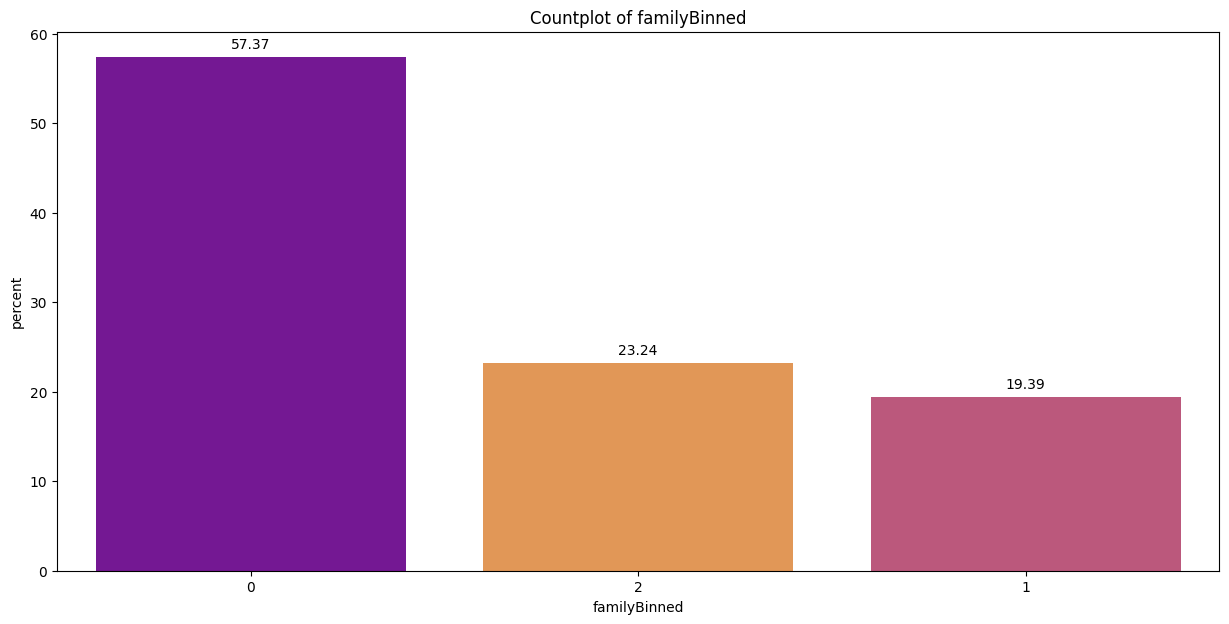

In [24]:
viz.countplot(train_set, cat_col='familyBinned', show_vals=True, stat='percent')

Check categorical relationship with `survived`

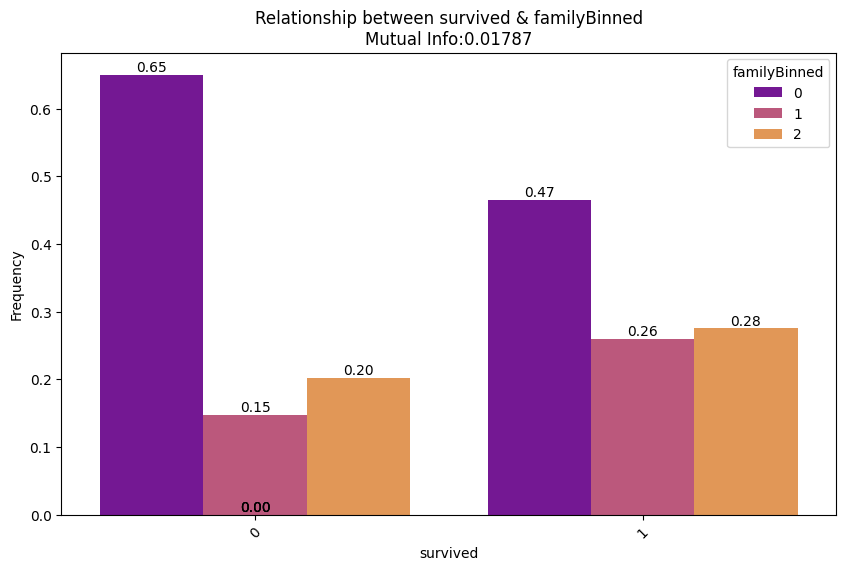

In [25]:
viz.categorical_relationships(train_set, cat_col1=target, cat_col2='familyBinned', show_values=True, relative_freq=True)

- lower proportion of survivors had 0 family aboard. Biggest change in proportions.
- higher proportion of survivors had 1 family member aboard.
- smallest proportional change in having 2 or more family members aboard.
- looks like a better indicator of survival could be simply if the passenger travelled with a family member or not (e.g. the variable alone)

Relationship between `alone` and `survival`

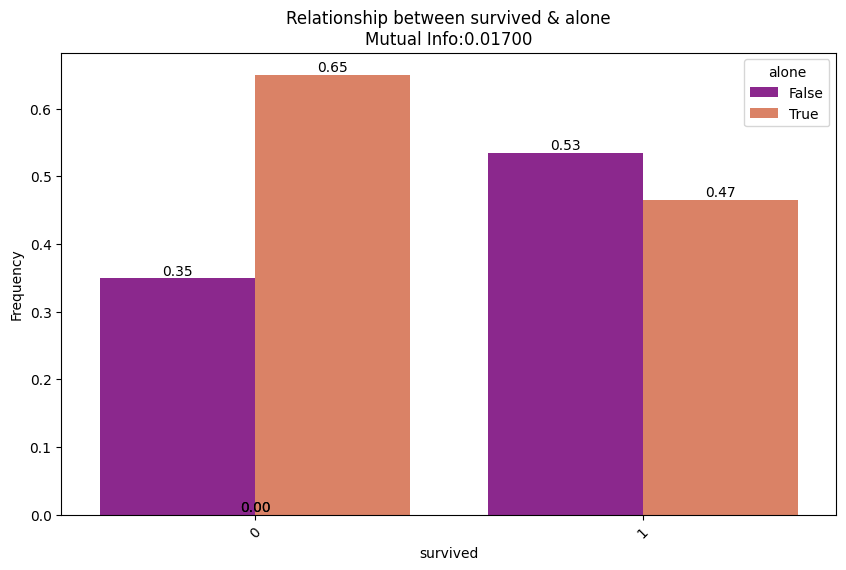

In [26]:
viz.categorical_relationships(train_set, cat_col1=target, cat_col2='alone', show_values=True, relative_freq=True)

- Shows a similar relationship to `familyBinned` with `survived`
- Mutual info score is slightly lower than for familyBinned but they are both so low that perhaps neither are particularly strong features, however they both show a clear difference in survival ratio.

**Decisions:**
- 'bestSet':
    - `alone`: keeps dummies more simple and possibly reduces extra noise that the extra class in familyBinned could add.
- 'possibly':
    - `familyBinned`

In [27]:
bestSet.append('alone')
possibly.append('familyBinned')

---

Each column in 'catFeatures' relationship with `survived`

- Excluding `alone` and `familyBinned` as already made decisions about these

In [28]:
catFeatures = ['pclass','sex','embarked','who','adult_male']

Categrical Feature: pclass


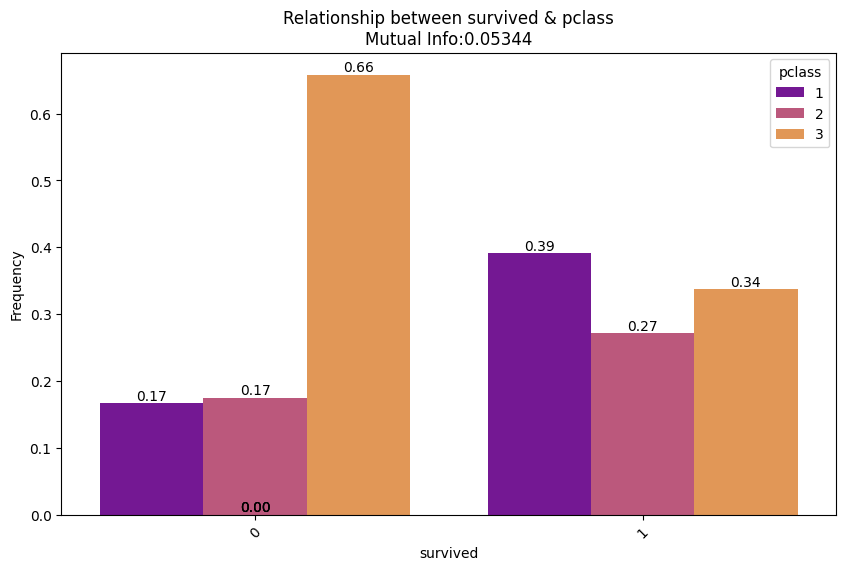

Categrical Feature: sex


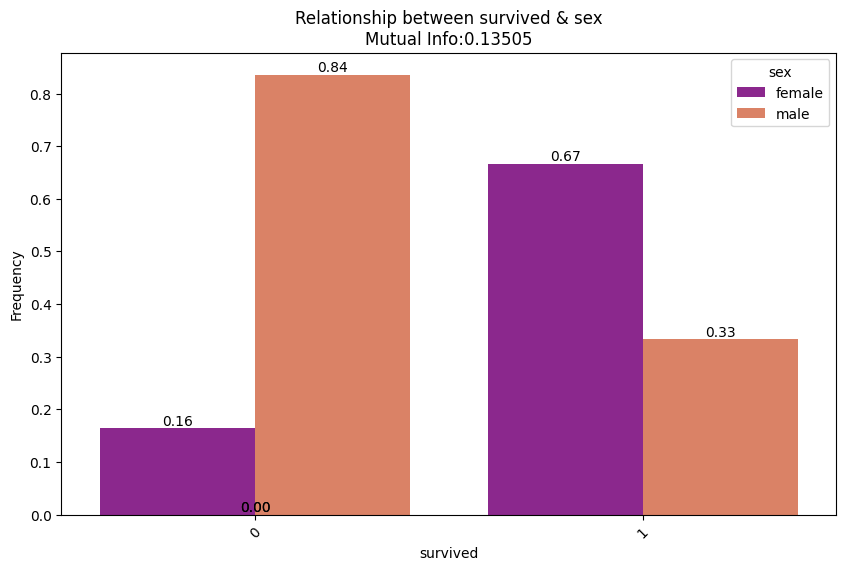

Categrical Feature: embarked


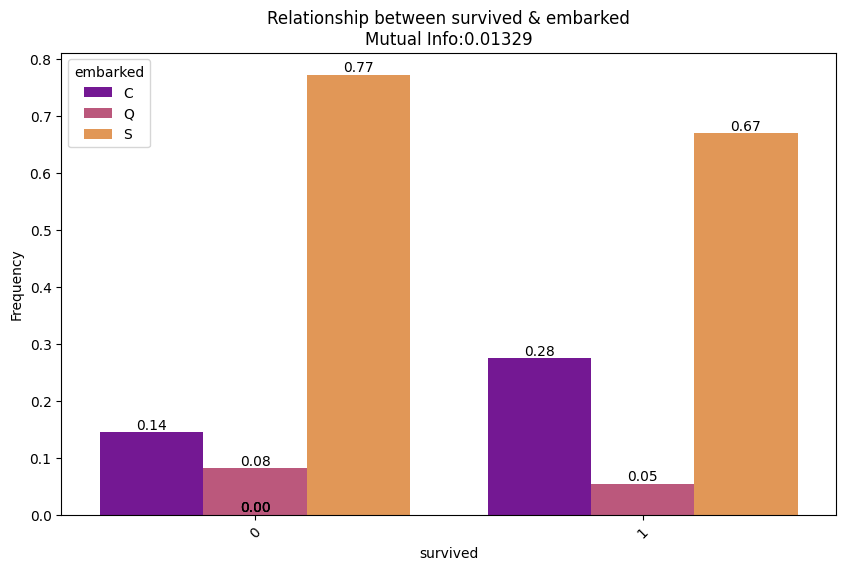

Categrical Feature: who


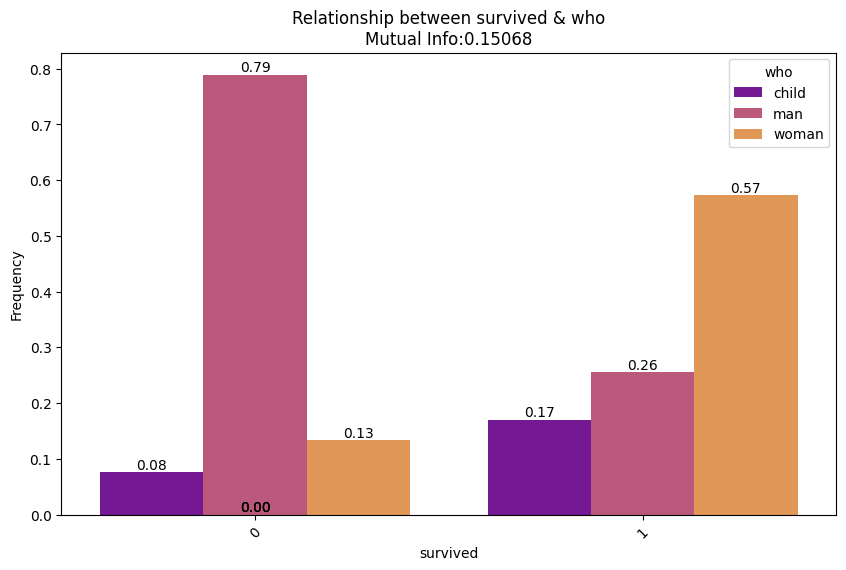

Categrical Feature: adult_male


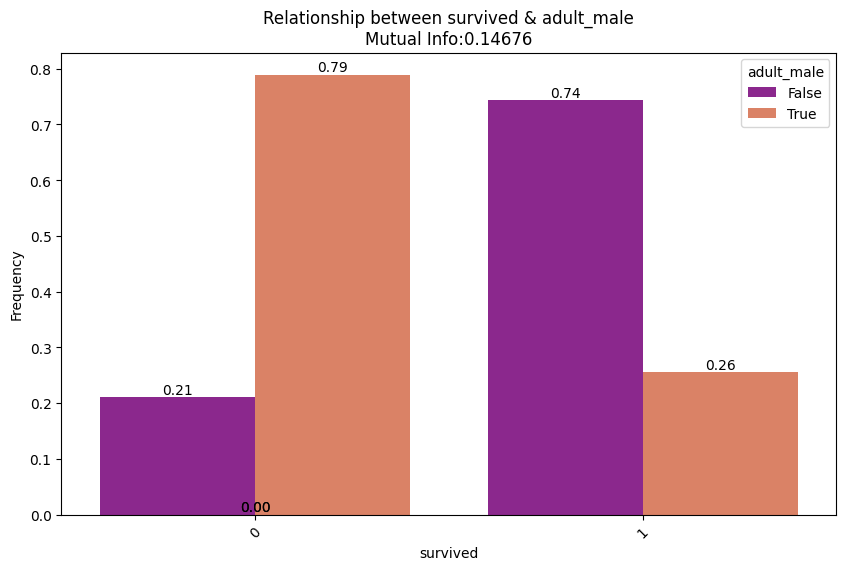

In [29]:
for feature in catFeatures:
    print(f'Categrical Feature: {feature}')
    viz.categorical_relationships(train_set, cat_col1=target, cat_col2=feature, show_values=True, relative_freq=True, palette='plasma')

- all show some change in proportions.
- keep them all

In [30]:
for col in catFeatures:
    bestSet.append(col)

---

Numerical features with `survived`

- `age` and `fare`

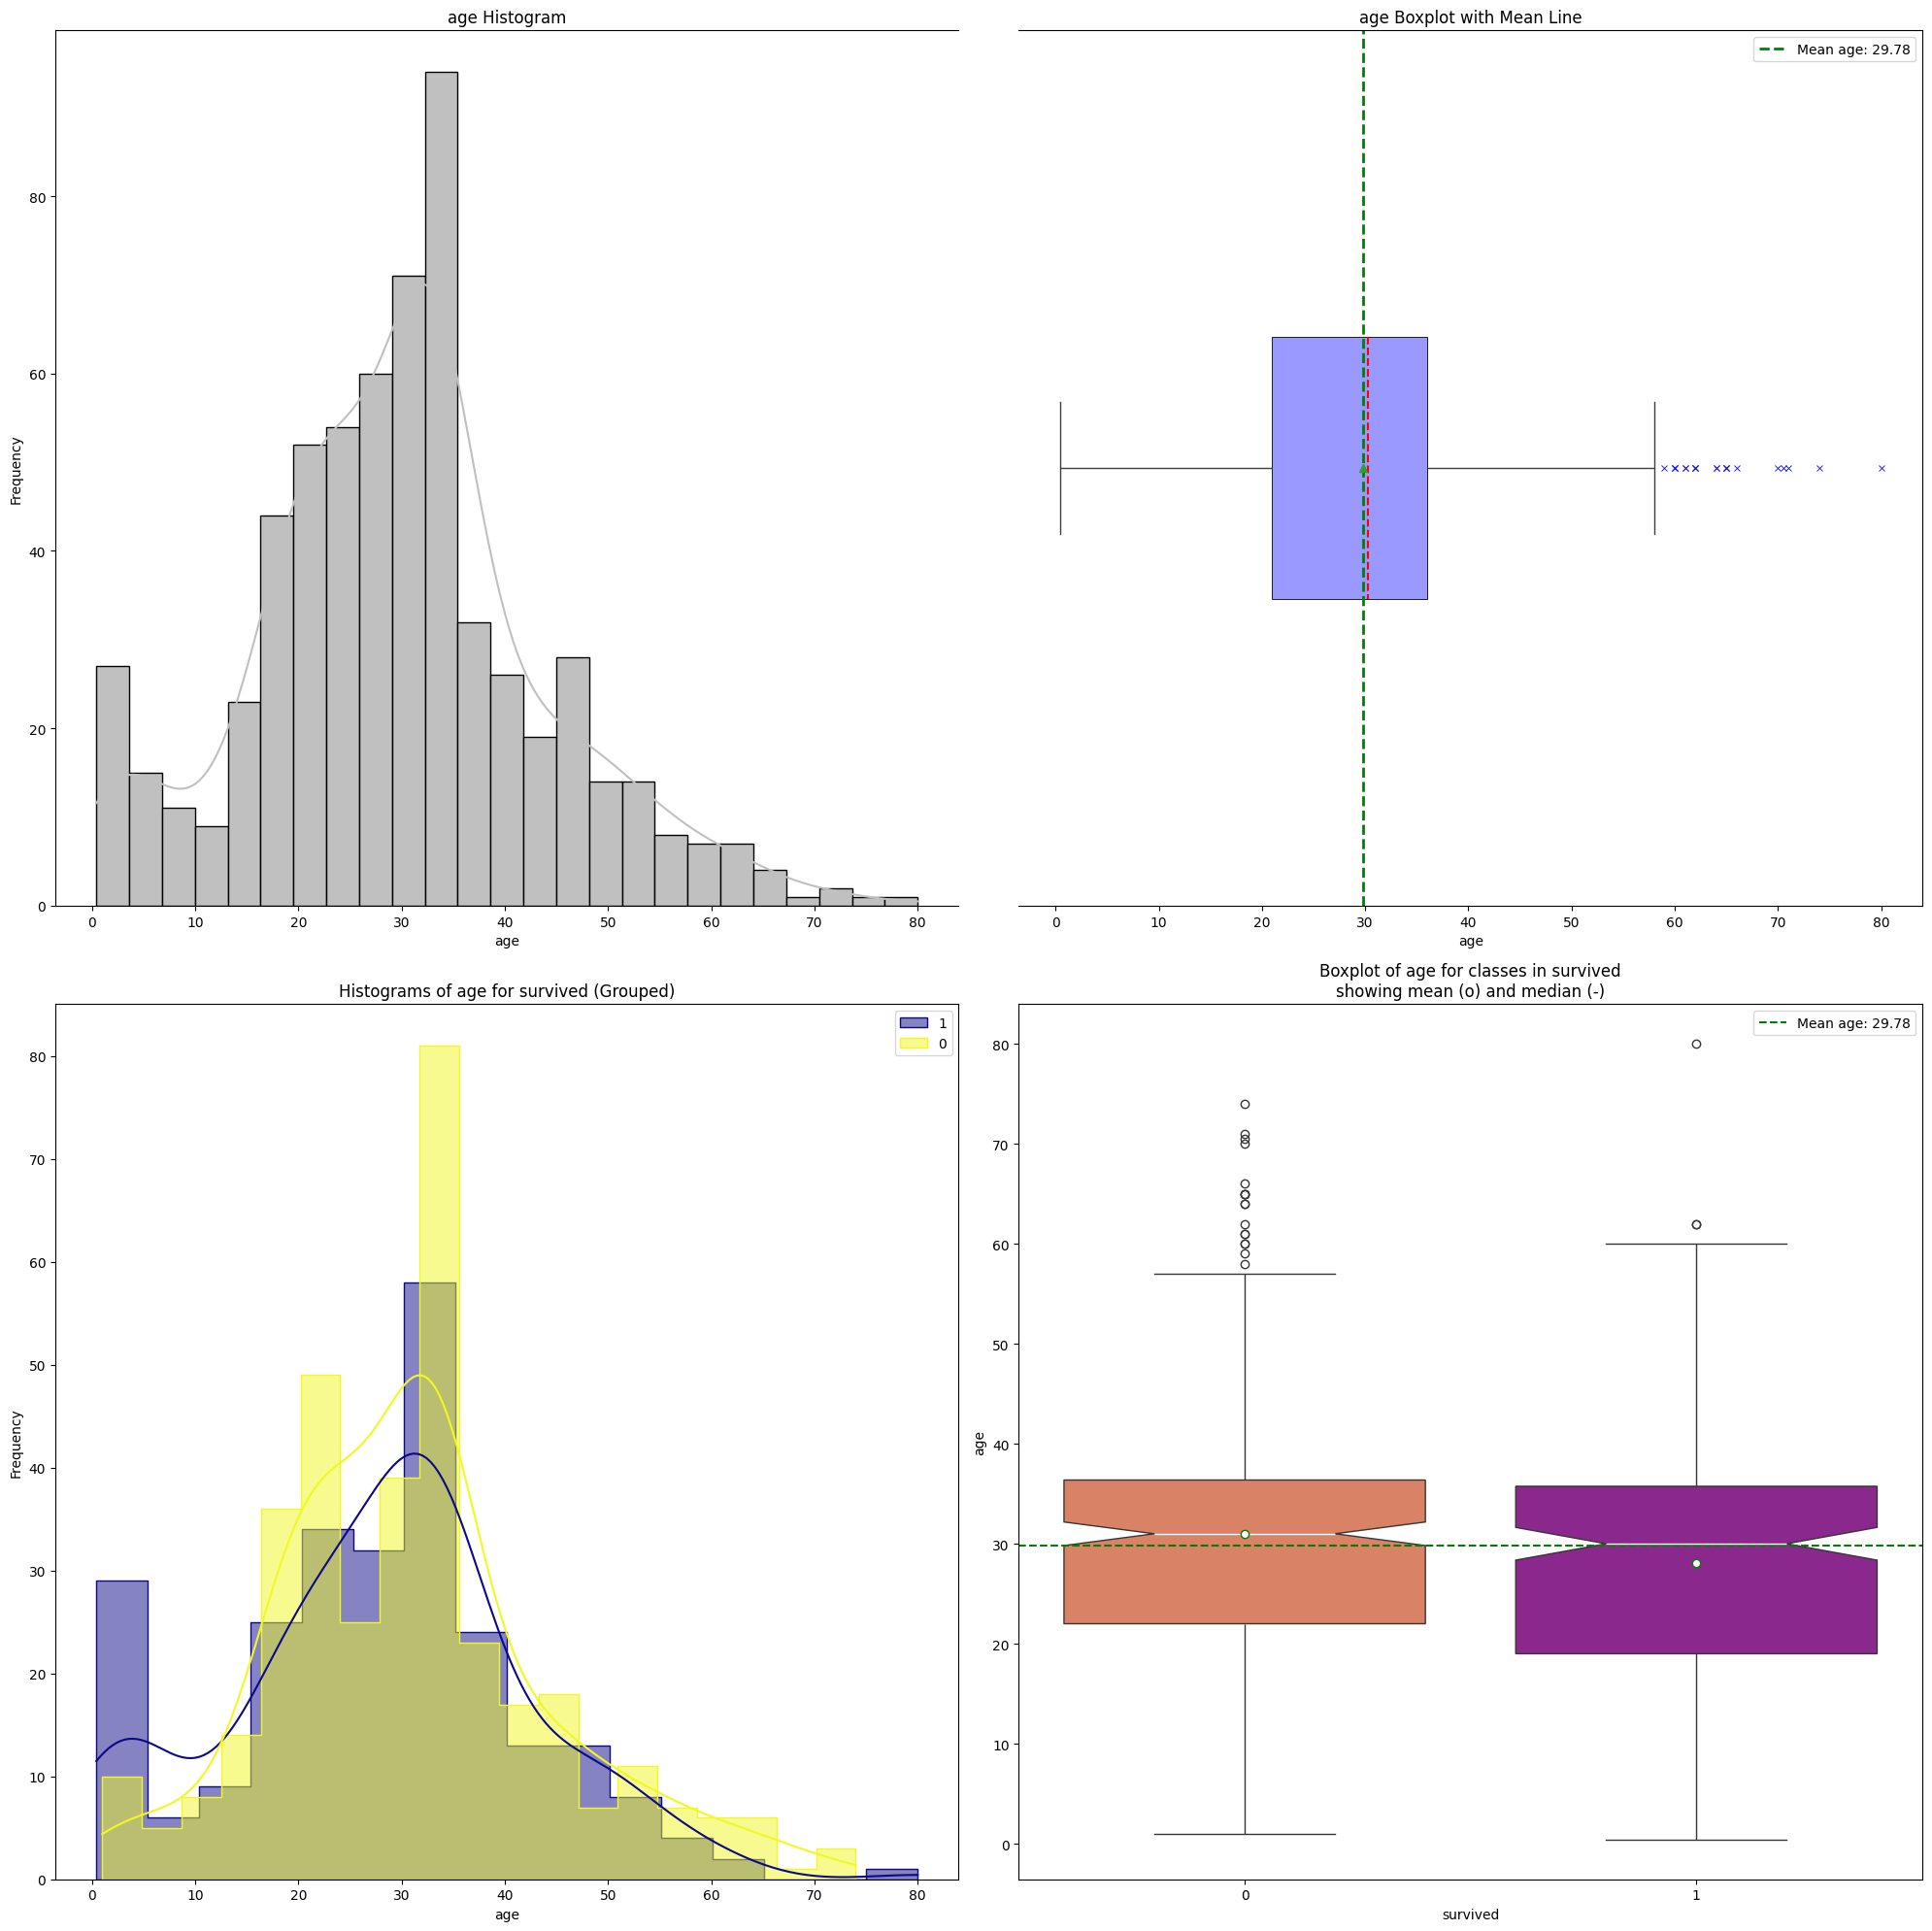

In [31]:
viz.plotAll4(train_set, cat_col=target, num_col='age', kde=True, show_mean=True)

- fairly Gaussian distribution. However, it seems like a good idea given the mlp models are very sensitive to scaling, probably also want a close to normal distribution.
- doesnt look like a particularly strong feature
- crossing of kde possibly indicator of younger ages being a good predictor of survival rate

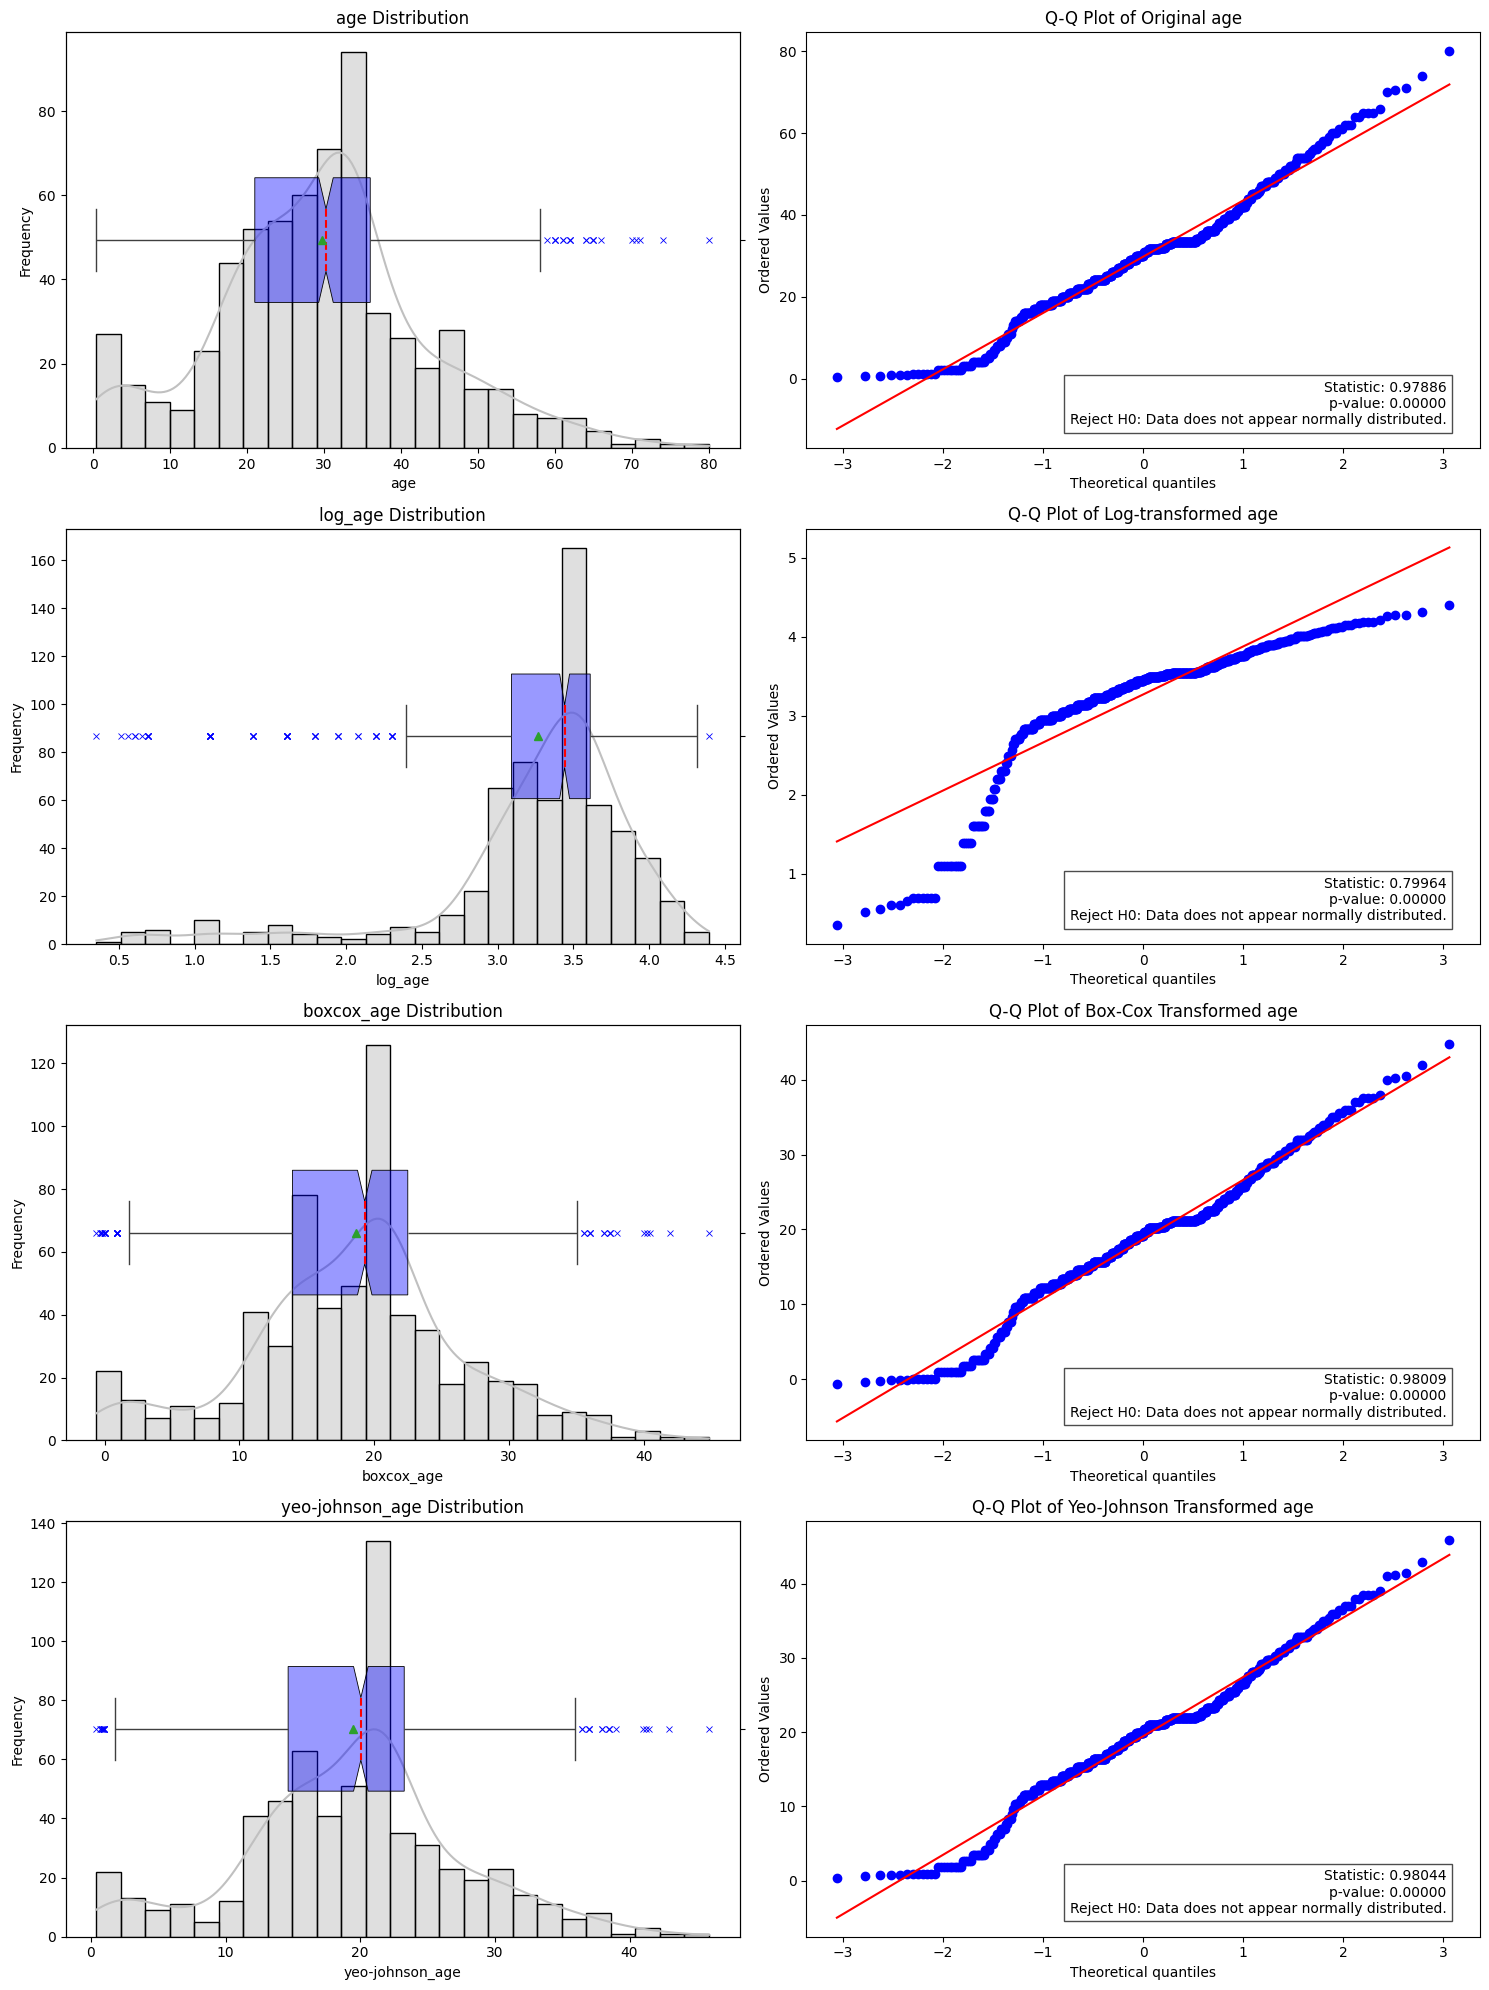

In [32]:
viz.transformed_distributions(train_set, num_col='age', transformations=('log','boxcox','yeo-johnson'))

- none of these transformations give a statistically "normal" Gasussian distribution.
- Closest is the yeo-johnson based on W-stat
- keep yeo-johnson_age for regression models

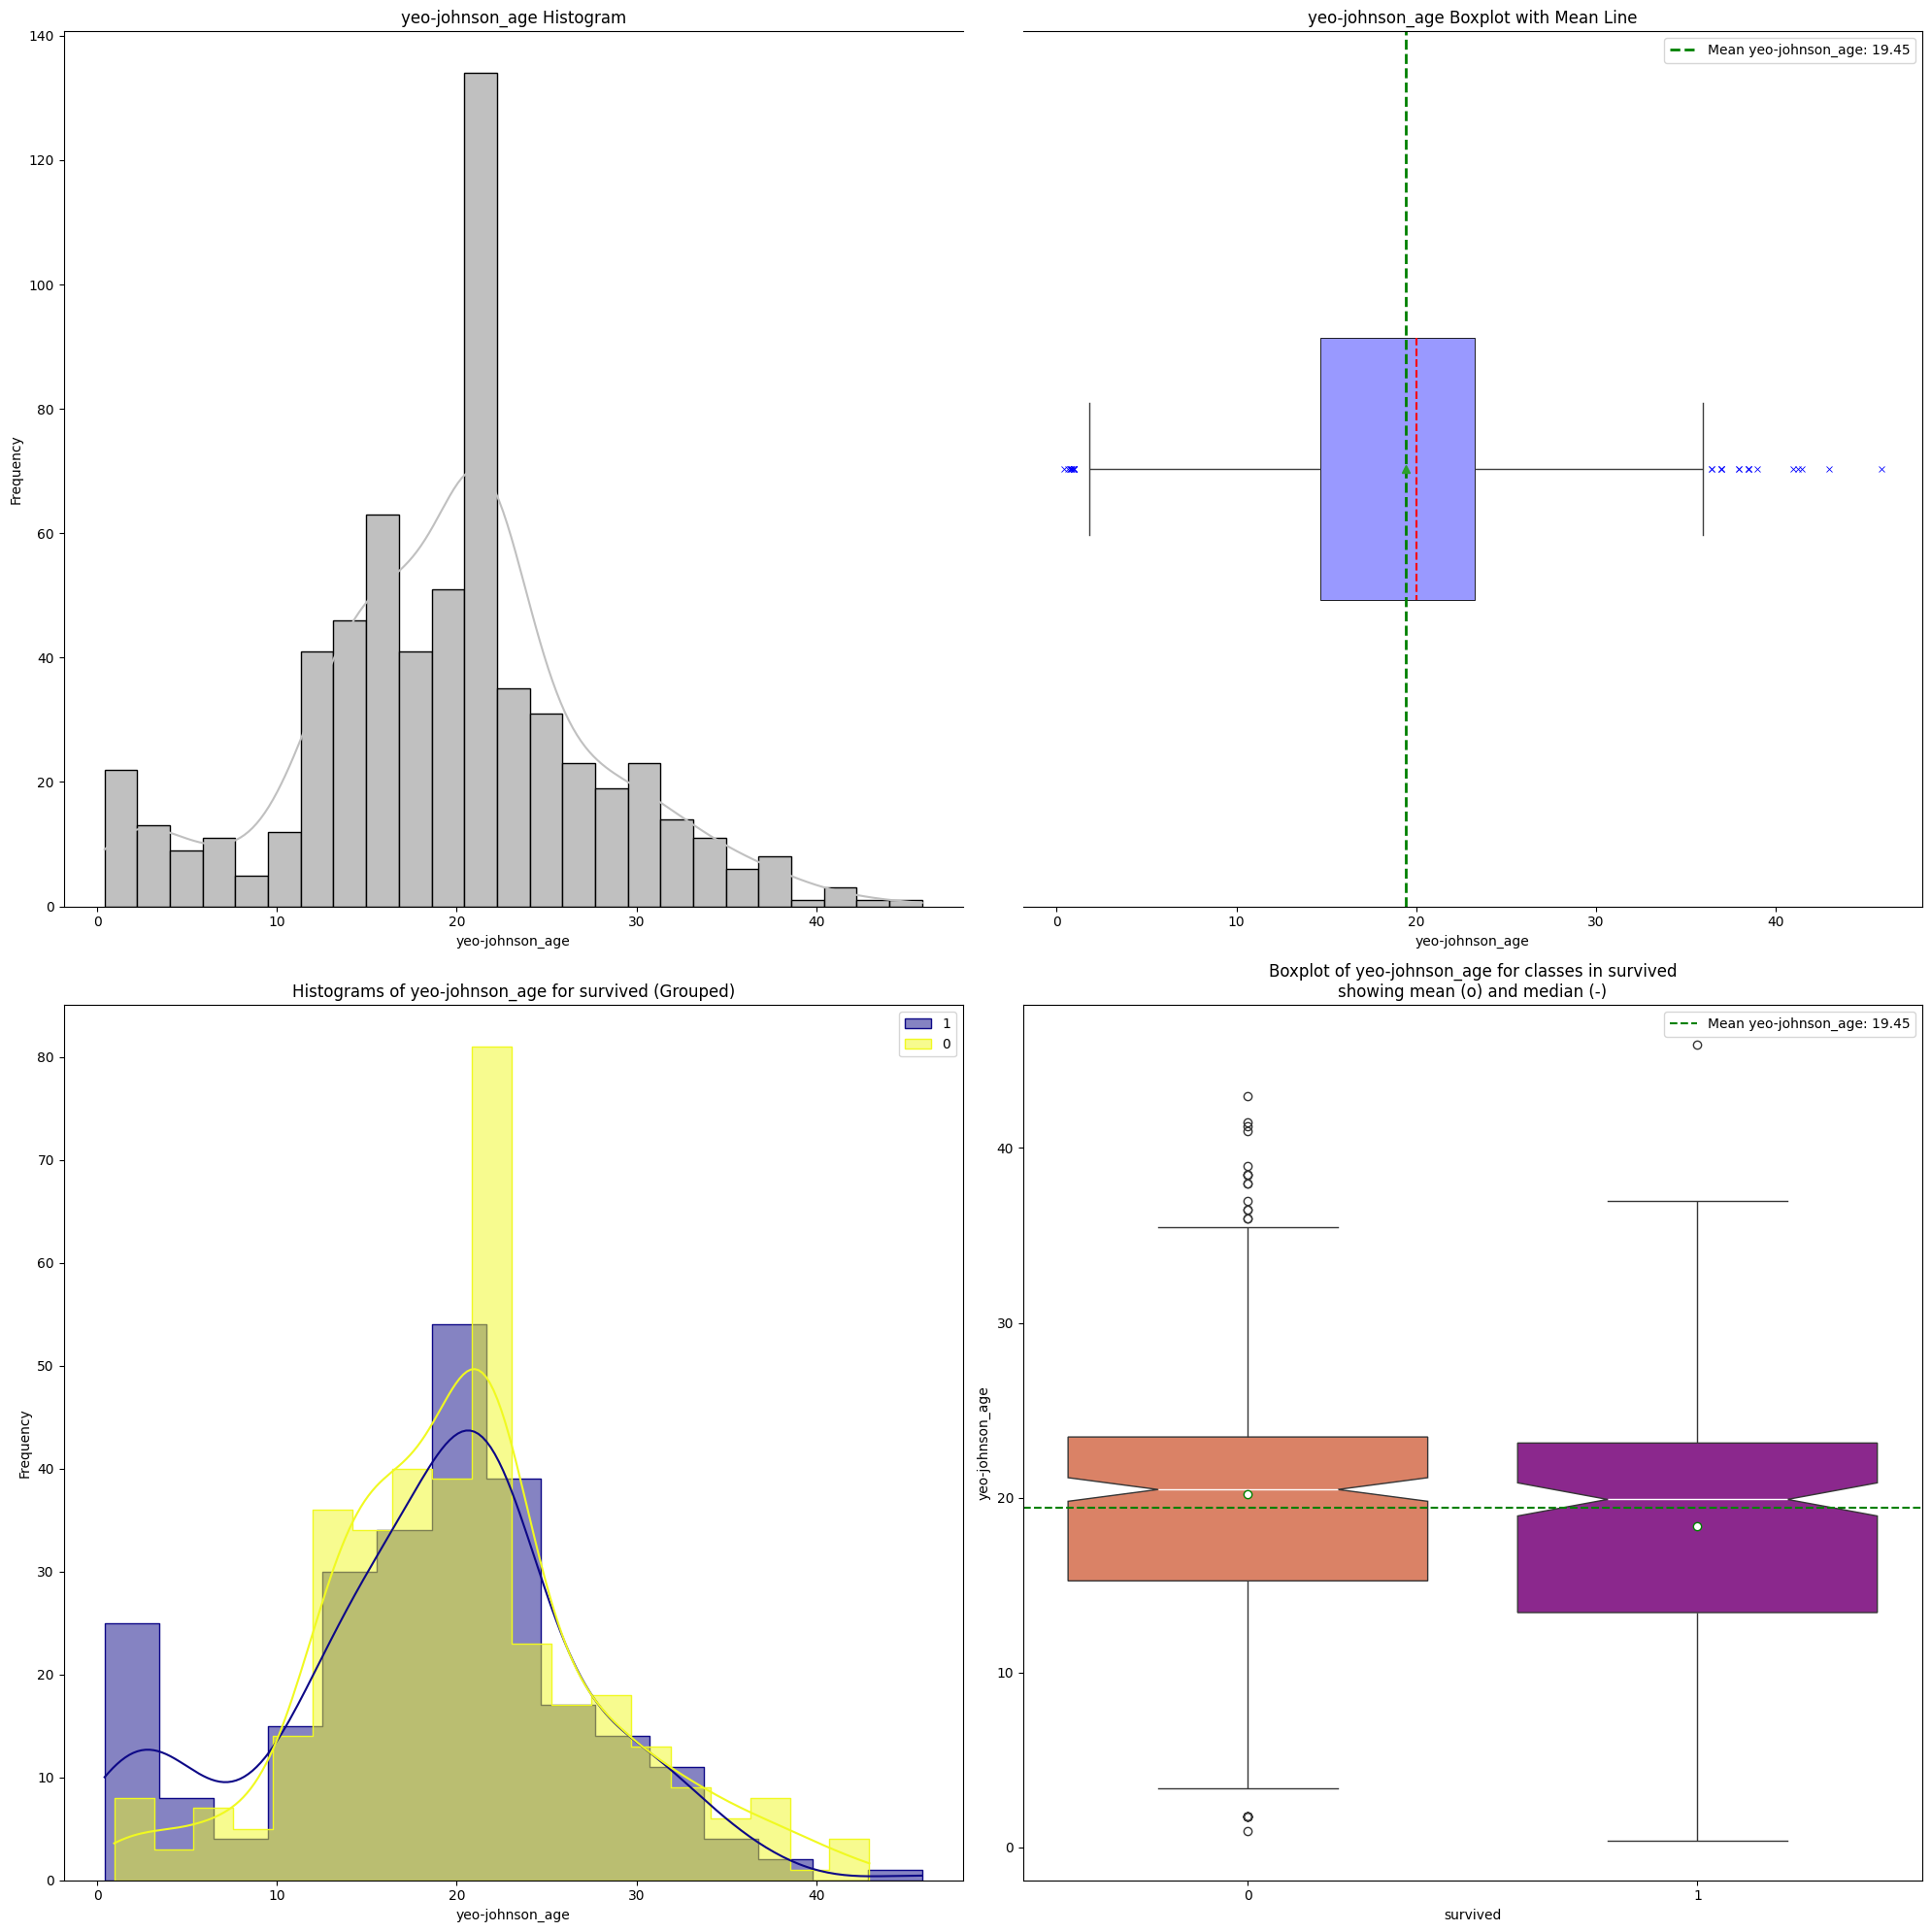

In [33]:
viz.plotAll4(train_set, cat_col=target, num_col='yeo-johnson_age', kde=True, show_mean=True)

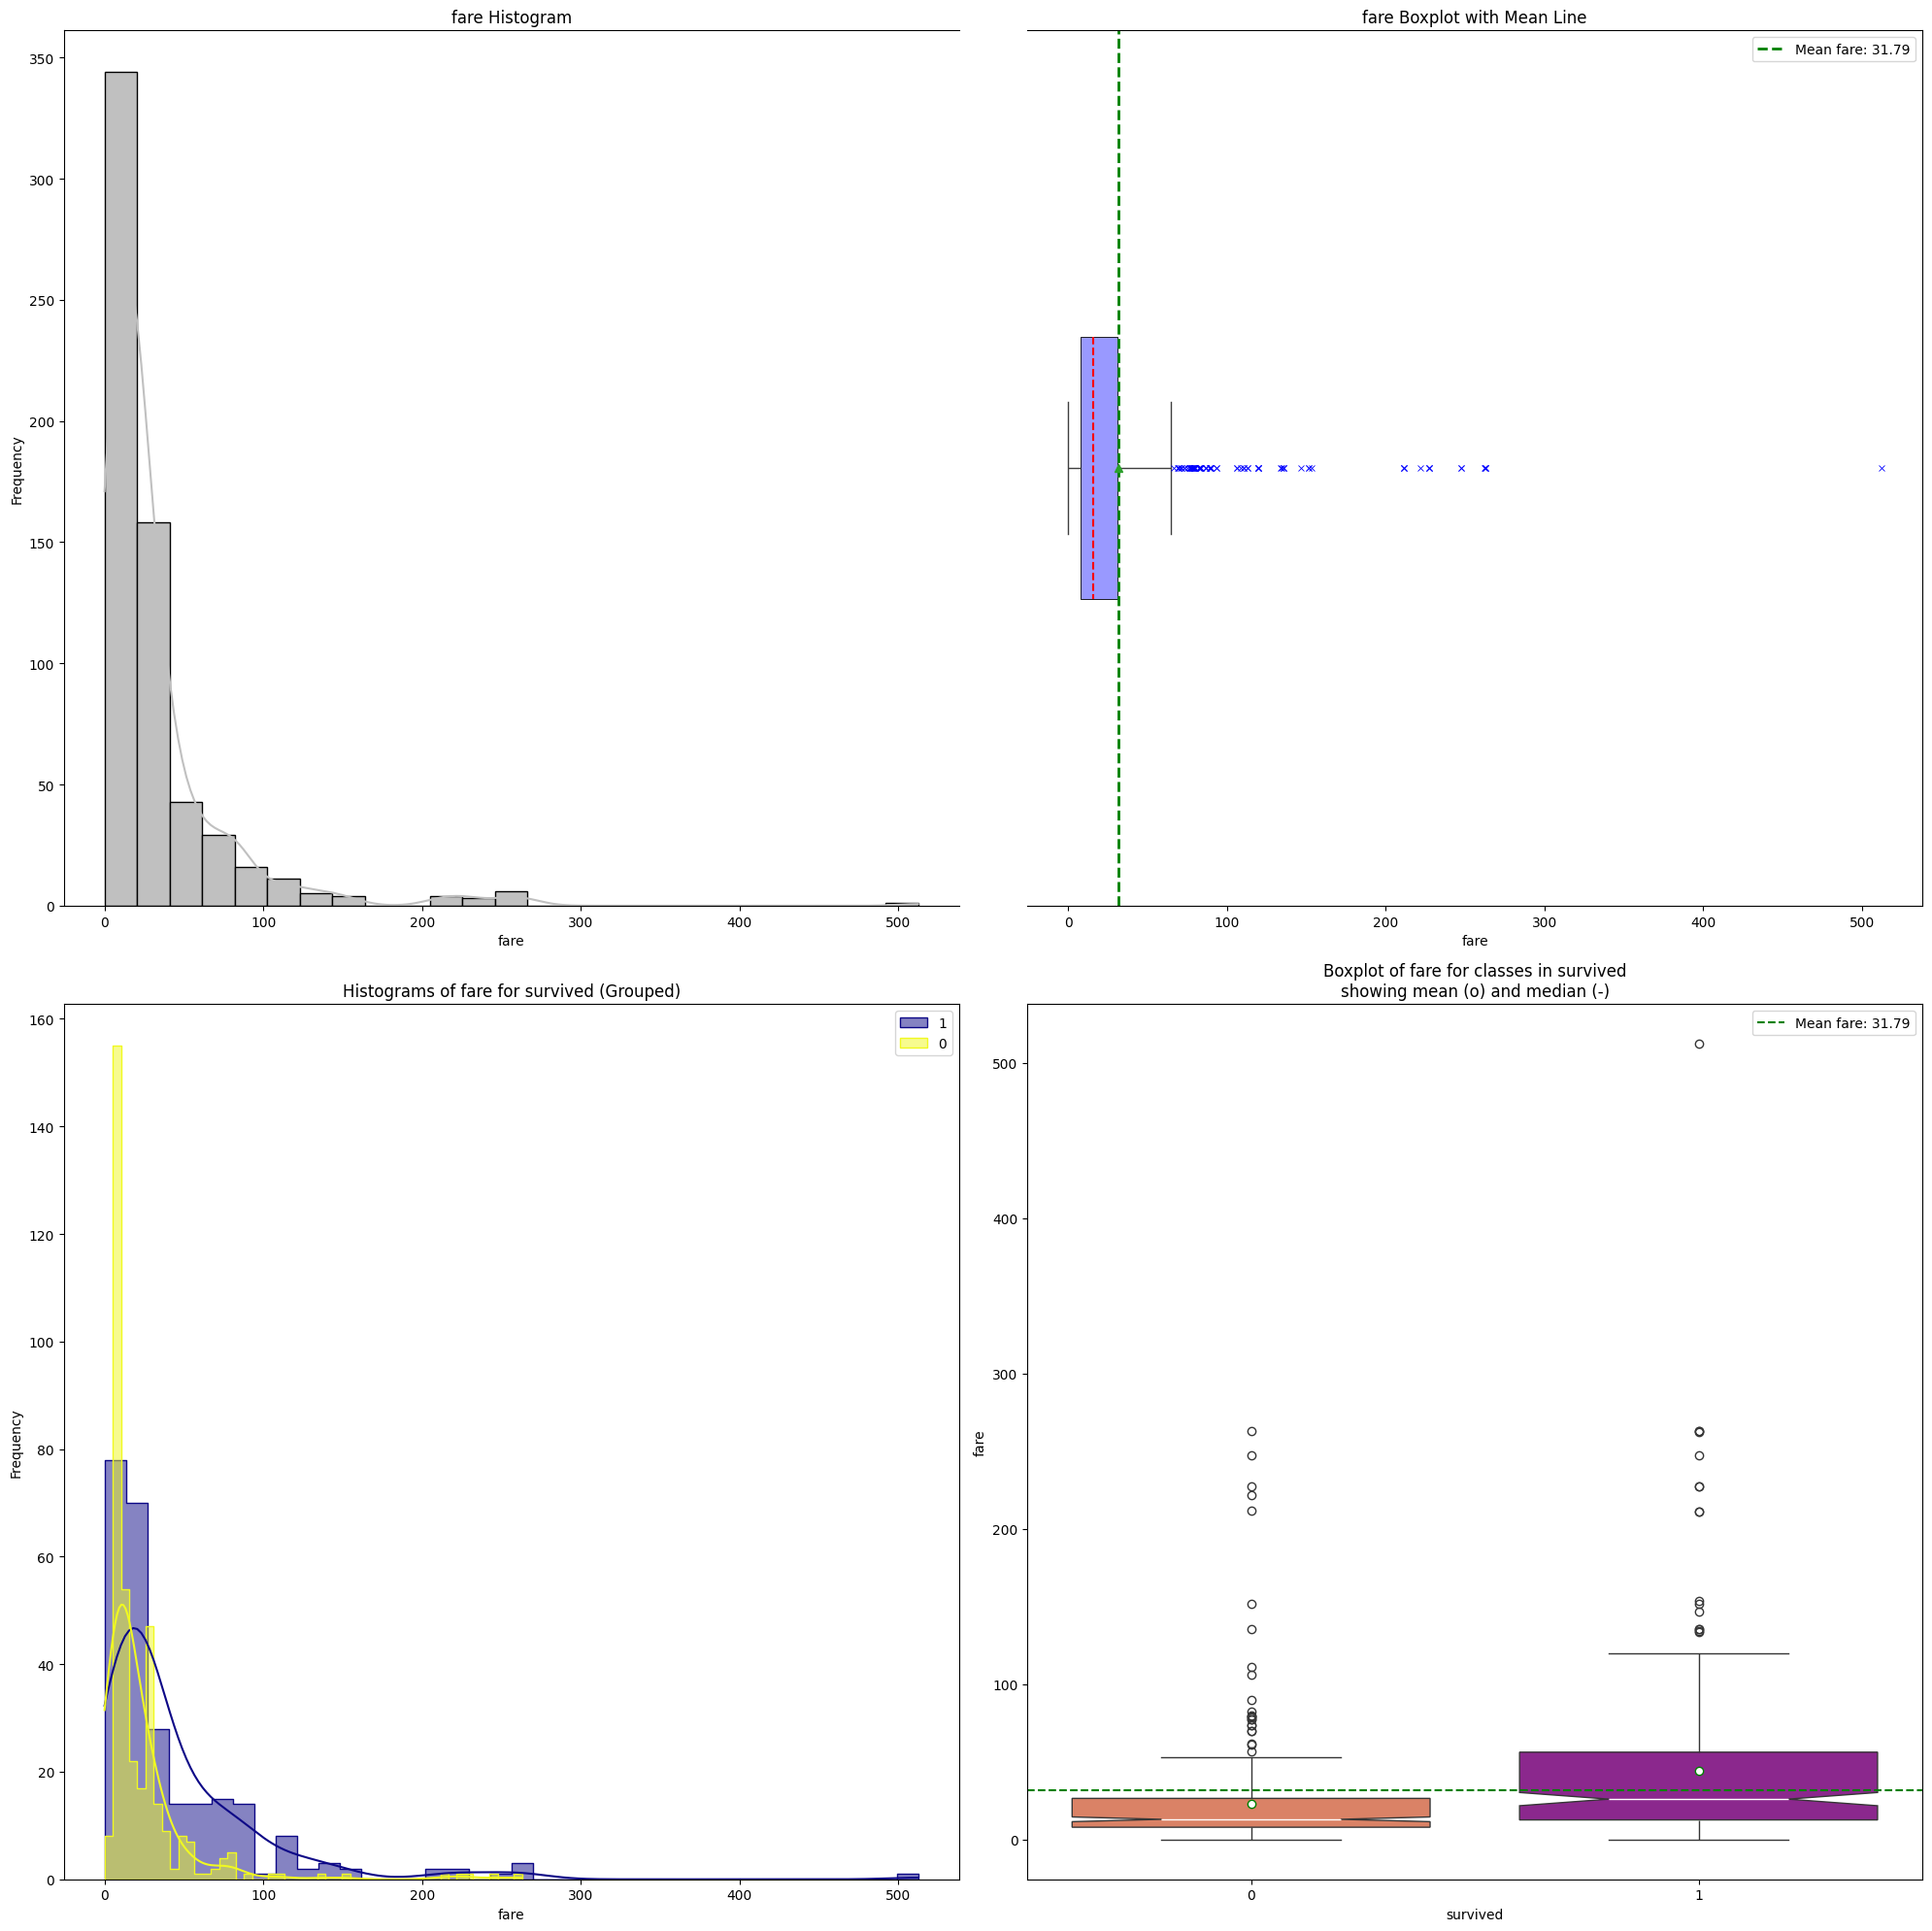

In [34]:
viz.plotAll4(train_set, cat_col=target, num_col='fare', kde=True, show_mean=True)

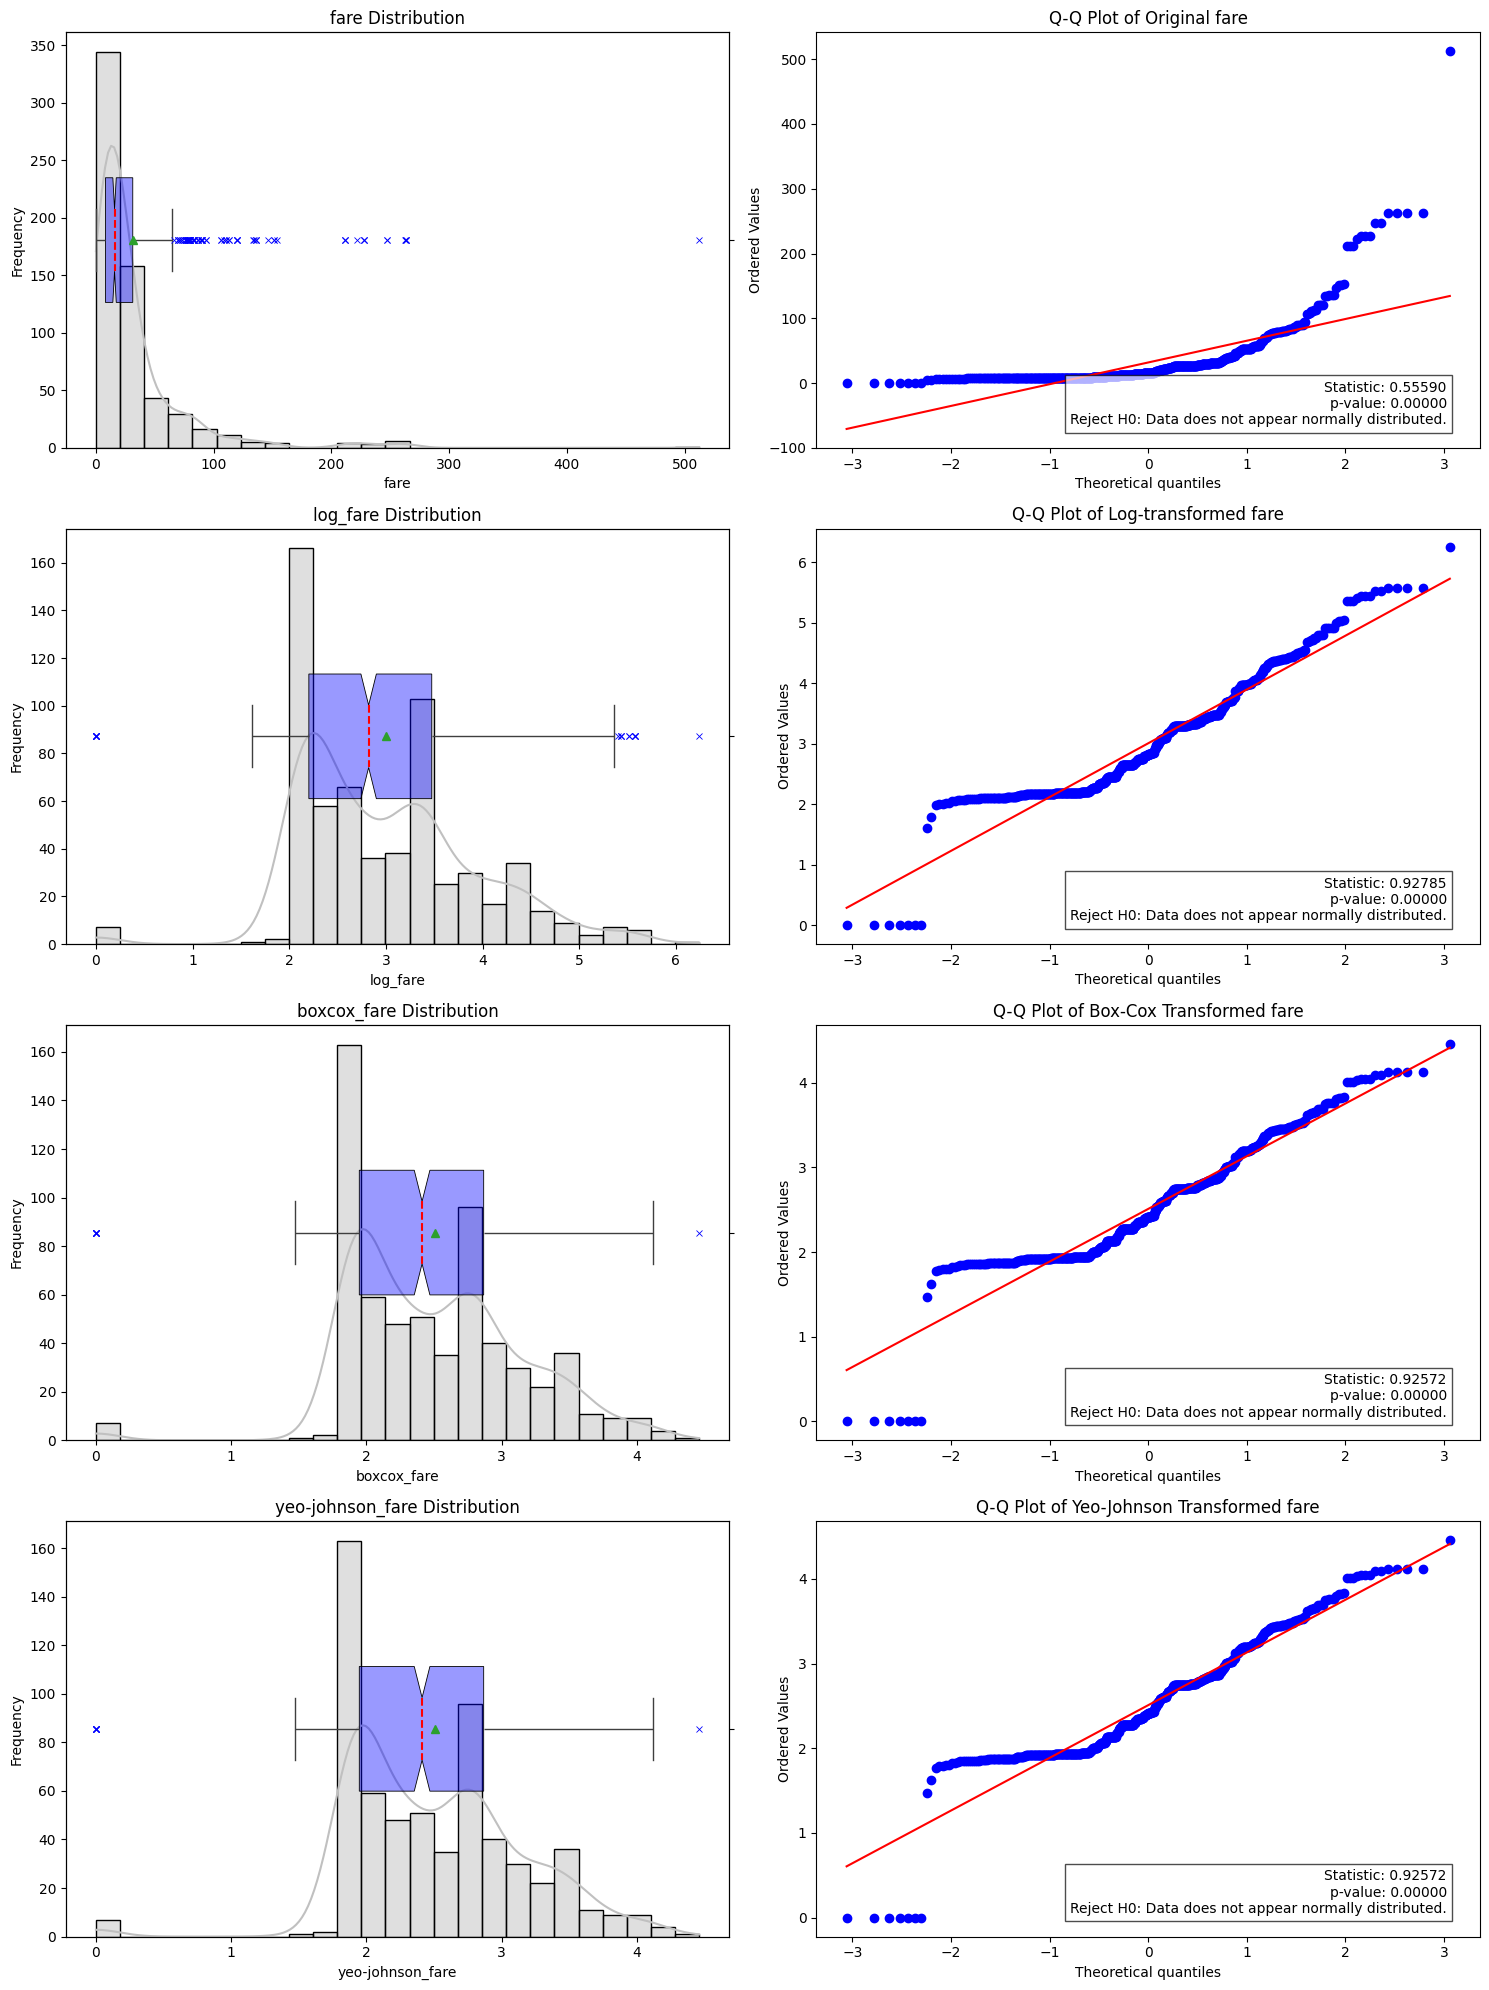

In [35]:
viz.transformed_distributions(train_set, num_col='fare', transformations=('log','boxcox','yeo-johnson'))

- again none of the transformations have given me a statistically normal distribution
- closest to normal is the log transformation
- will keep the log_fare

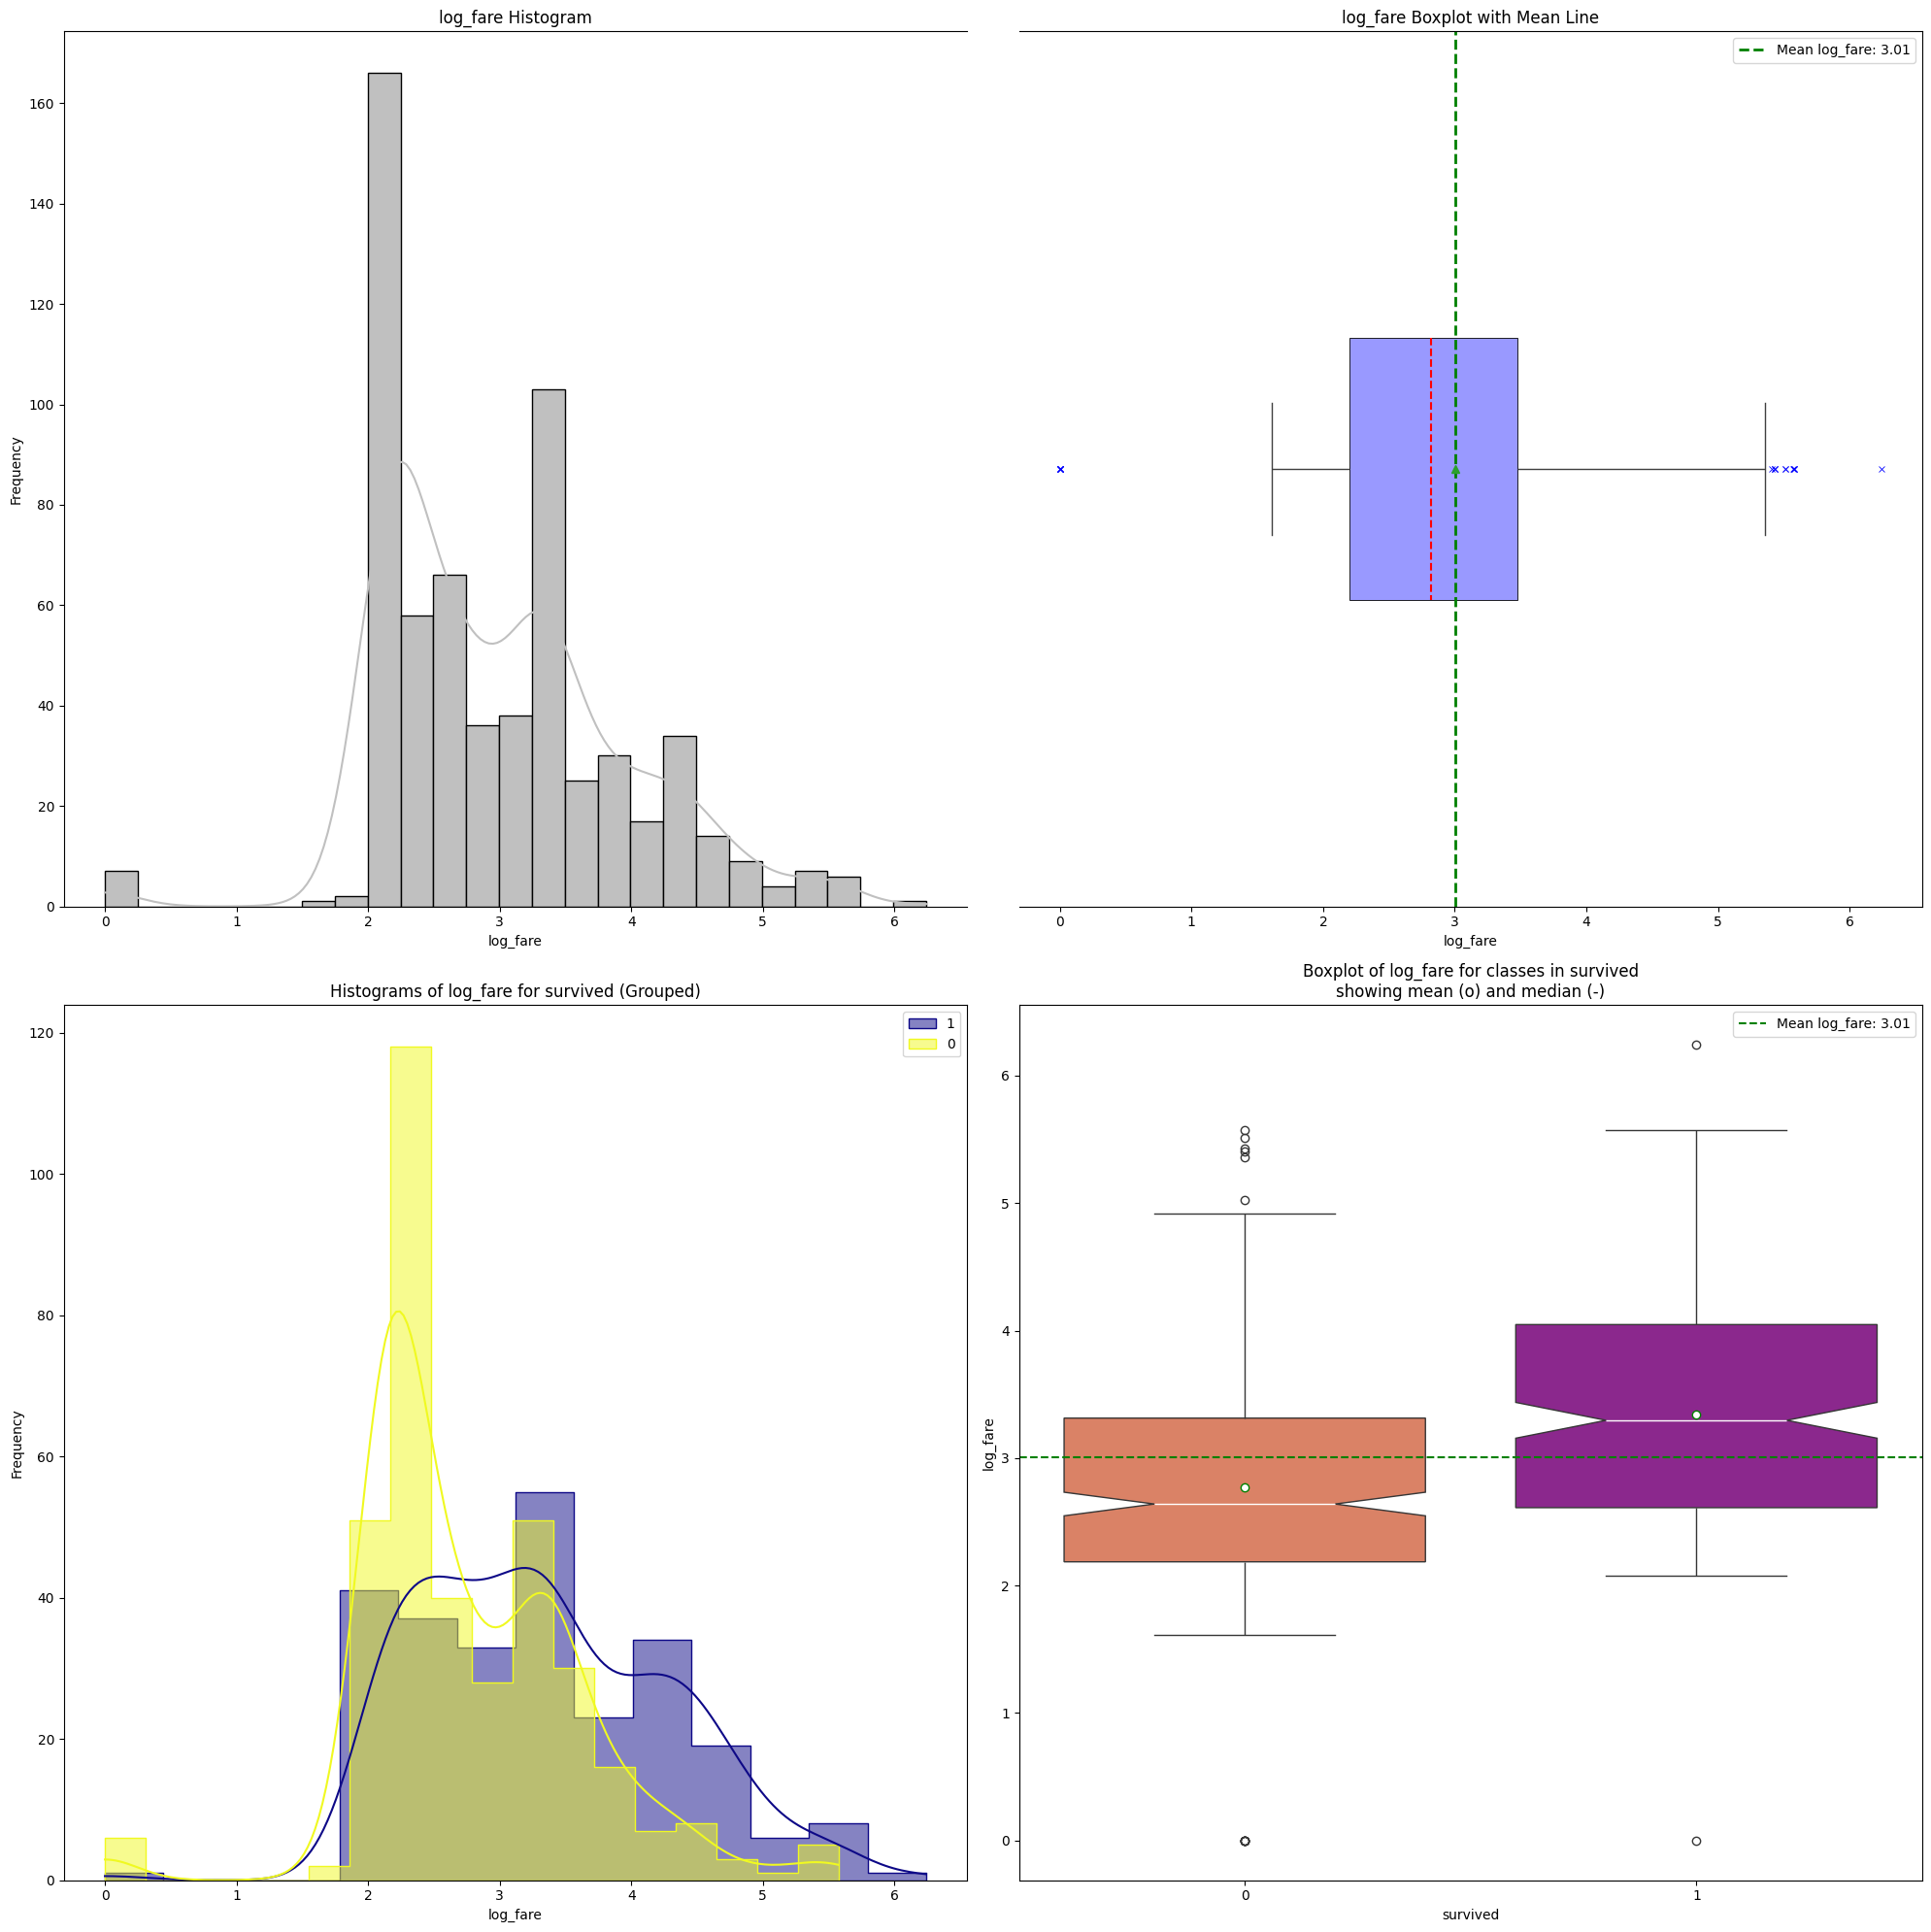

In [36]:
viz.plotAll4(train_set, cat_col=target, num_col='log_fare', kde=True, show_mean=True)

- not sure there is much sense in a pairplot given there are only 2 numeric features left + the transformations
    - `age` and `fare`

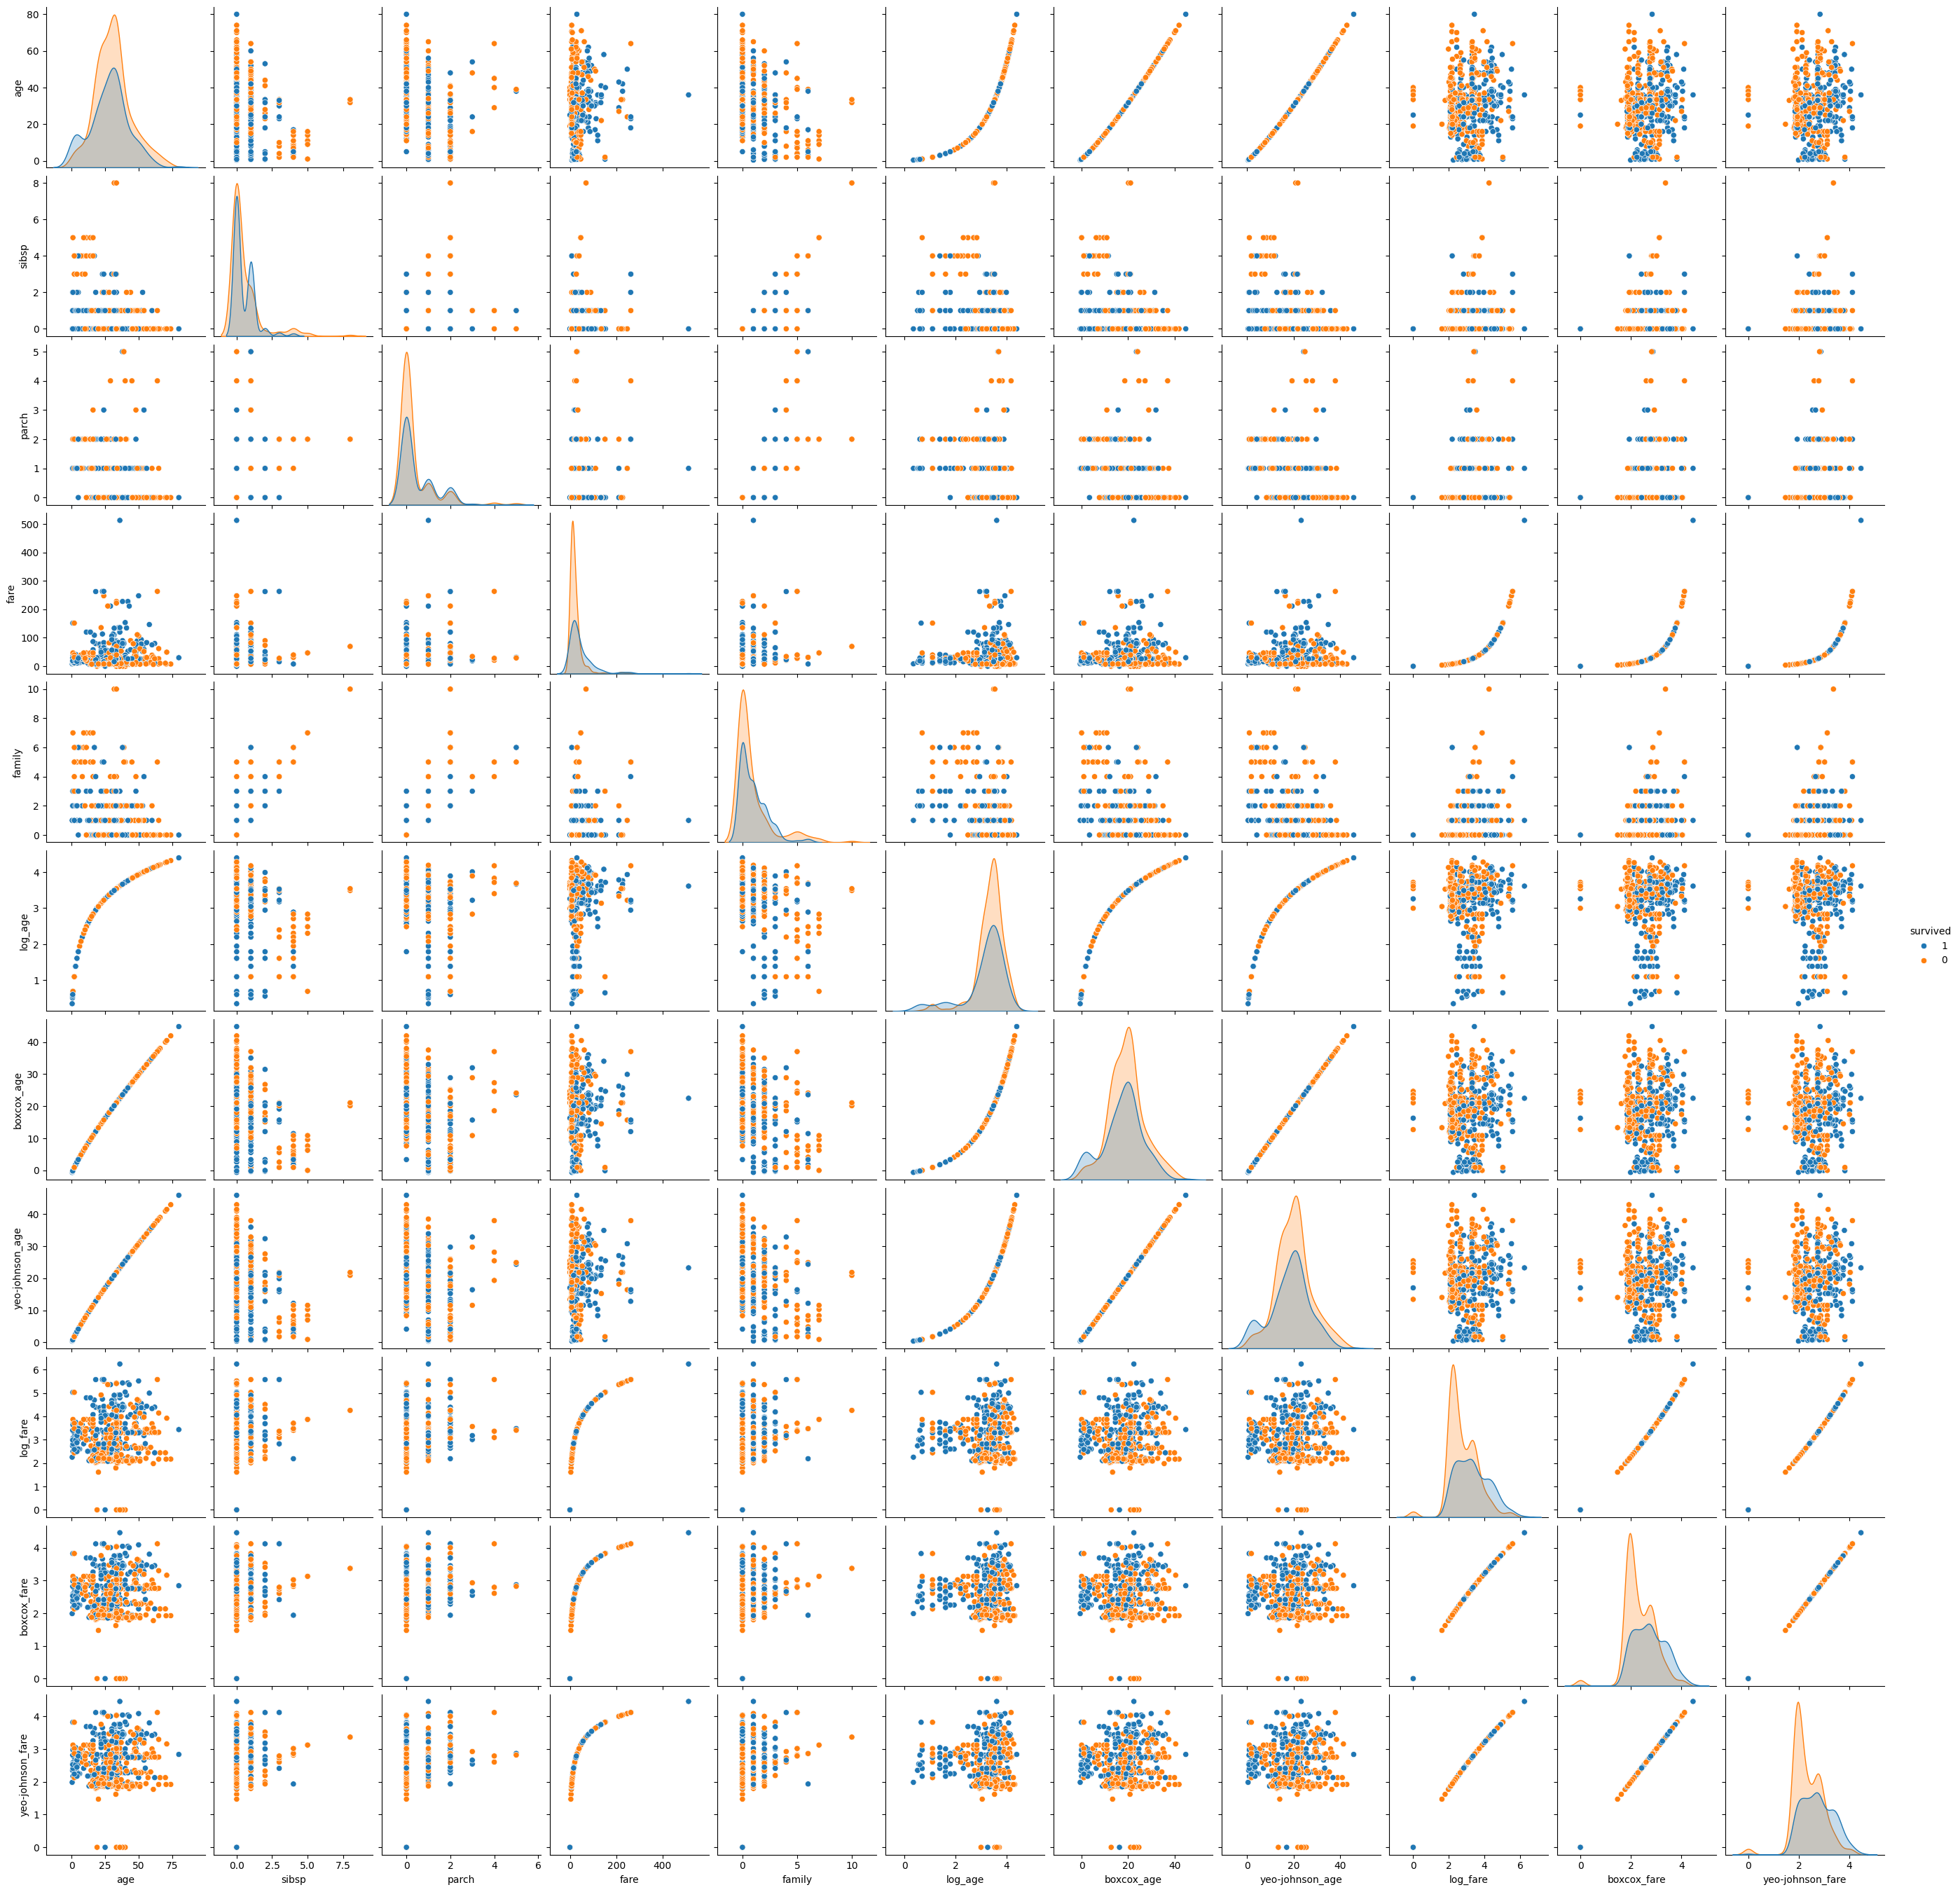

In [37]:
sns.pairplot(train_set, hue=target)

Only colinearity check is between `age` and `fare`

In [38]:
train_set['age'].corr(train_set['fare'])

0.10875190971364844

Correlation: 0.1087519097136484


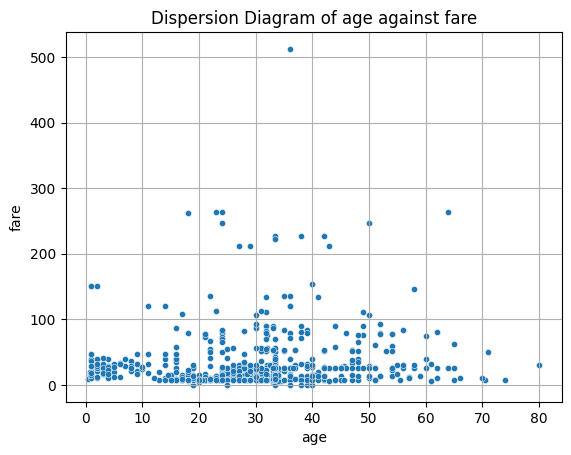

In [39]:
viz.dispersion(train_set, x='age', y='fare')

- very low correlation between num features.
- no worries of colinearity between the numerical features
- Could be a good time to try the phik heatmap (for now going to leave this and will play with it as a side project)

---

In [40]:
train_set.head()

survived pclass     sex   age  sibsp  parch     fare embarked    who  \
710        1      1  female  24.0      0      0  49.5042        C  woman   
830        1      3  female  15.0      1      0  14.4542        C  child   
114        0      3  female  17.0      0      0  14.4583        C  woman   
652        0      3    male  21.0      0      0   8.4333        S    man   
624        0      3    male  21.0      0      0  16.1000        S    man   

    adult_male  alone  family familyBinned   log_age  boxcox_age  \
710      False   True       0            0  3.218876   15.709452   
830      False  False       1            1  2.772589   10.236287   
114      False   True       0            0  2.890372   11.491589   
652       True   True       0            0  3.091042   13.931307   
624       True   True       0            0  3.091042   13.931307   

     yeo-johnson_age  log_fare  boxcox_fare  yeo-johnson_fare  
710        16.433380  3.922057     3.159617          3.159617  
830        10.944775  2.737881     2.350247          2.350247  
114        12.200731  2.738146     2.350441          2.350441  
652        14.646987  2.244246     1.979069          1.979069  
624        14.646987  2.839078     2.423783          2.423783

In [41]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 710 to 89
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   survived          624 non-null    object 
 1   pclass            624 non-null    object 
 2   sex               624 non-null    object 
 3   age               624 non-null    float64
 4   sibsp             624 non-null    int64  
 5   parch             624 non-null    int64  
 6   fare              624 non-null    float64
 7   embarked          624 non-null    object 
 8   who               624 non-null    object 
 9   adult_male        624 non-null    object 
 10  alone             624 non-null    object 
 11  family            624 non-null    int64  
 12  familyBinned      624 non-null    object 
 13  log_age           624 non-null    float64
 14  boxcox_age        624 non-null    float64
 15  yeo-johnson_age   624 non-null    float64
 16  log_fare          624 non-null    float64
 

- i guess its OK to see the data info on the test set
- had to do this as for some reason the train set and test set had differently assigned object, and bool to `alone` and `adult_male` which caused complications when trying to convert to binary data types

In [42]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 336 to 850
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    156 non-null    int64  
 1   pclass      156 non-null    int64  
 2   sex         156 non-null    object 
 3   age         156 non-null    float64
 4   sibsp       156 non-null    int64  
 5   parch       156 non-null    int64  
 6   fare        156 non-null    float64
 7   embarked    156 non-null    object 
 8   who         156 non-null    object 
 9   adult_male  156 non-null    bool   
 10  alone       156 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(3)
memory usage: 12.5+ KB


In [43]:
bestFeaturesCat = ['pclass','sex','embarked','who','adult_male','alone']
bestFeaturesNumReg = ['yeo-johnson_age','log_fare']
bestFeaturesNum = ['age','fare']

In [44]:
train_set['sex'] = train_set['sex'].apply(lambda x: 1 if x== 'male' else 0)

In [45]:
test_set['sex'] = test_set['sex'].apply(lambda x: 1 if x== 'male' else 0)

In [46]:
train_set.sex.value_counts()

1    392
0    232
Name: sex, dtype: int64

In [47]:
train_set['adult_male'] = train_set['adult_male'].replace({'True': 1, 'False': 0})

In [48]:
test_set['adult_male'] = test_set['adult_male'].astype(int)

In [49]:
train_set['adult_male'].value_counts()

1    355
0    269
Name: adult_male, dtype: int64

In [50]:
train_set['alone'] = train_set['alone'].replace({'True': 1, 'False': 0})

In [51]:
train_set.alone.value_counts()

1    358
0    266
Name: alone, dtype: int64

In [52]:
test_set['alone'] = test_set['alone'].astype(int)

In [53]:
train_set['embarked'] = train_set['embarked'].map({'S':0, 'Q':1, 'C':2})

In [54]:
train_set.embarked.value_counts()

0    456
2    124
1     44
Name: embarked, dtype: int64

In [55]:
test_set['embarked'] = test_set['embarked'].map({'S':0, 'Q':1, 'C':2})

In [56]:
train_set['who'] = train_set['who'].map({'woman':0,'man':1,'child':2})

In [57]:
train_set.who.value_counts()

1    355
0    197
2     72
Name: who, dtype: int64

In [58]:
test_set['who'] = test_set['who'].map({'woman':0,'man':1,'child':2})

In [59]:
from scipy import stats

In [60]:
yjAge, lambdaVal = stats.yeojohnson(test_set['age'])
test_set['yeo-johnson_age'] = yjAge

In [61]:
if (test_set['fare'] <= 0).any():
    shiftVal = abs(test_set['fare'].min()) + 1
    test_set['log_fare'] = np.log(test_set['fare'] + shiftVal)
else:
    test_set['log_fare'] = np.log1p(test_set['fare'])

In [62]:
regFeatures = bestFeaturesCat + bestFeaturesNumReg + [target]
features = bestFeaturesCat + bestFeaturesNum + [target]

In [63]:
train_set['survived'] = train_set['survived'].astype(int)

In [64]:
train = train_set[features].copy()
train = pd.get_dummies(train, columns=bestFeaturesCat)

test = test_set[features].copy()
test = pd.get_dummies(test, columns=bestFeaturesCat)

train_scaled = train_set[regFeatures].copy()
train_scaled = pd.get_dummies(train_scaled, columns=bestFeaturesCat)

test_scaled = test_set[regFeatures].copy()
test_scaled = pd.get_dummies(test_scaled, columns=bestFeaturesCat)


In [65]:
train_scaled

yeo-johnson_age  log_fare  survived  pclass_1  pclass_2  pclass_3  sex_0  \
710        16.433380  3.922057         1         1         0         0      1   
830        10.944775  2.737881         1         0         0         1      1   
114        12.200731  2.738146         0         0         0         1      1   
652        14.646987  2.244246         0         0         0         1      0   
624        14.646987  2.839078         0         0         0         1      0   
..               ...       ...       ...       ...       ...       ...    ...   
203        28.417331  2.107178         0         0         0         1      0   
766        21.846390  3.703768         0         1         0         0      0   
347        20.913289  2.839078         1         0         0         1      1   
58          4.152349  3.358638         1         0         1         0      1   
89         16.433380  2.202765         0         0         0         1      0   

     sex_1  embarked_0  embarked_1  embarked_2  who_0  who_1  who_2  \
710      0           0           0           1      1      0      0   
830      0           0           0           1      0      0      1   
114      0           0           0           1      1      0      0   
652      1           1           0           0      0      1      0   
624      1           1           0           0      0      1      0   
..     ...         ...         ...         ...    ...    ...    ...   
203      1           0           0           1      0      1      0   
766      1           0           0           1      0      1      0   
347      0           1           0           0      1      0      0   
58       0           1           0           0      0      0      1   
89       1           1           0           0      0      1      0   

     adult_male_0  adult_male_1  alone_0  alone_1  
710             1             0        0        1  
830             1             0        1        0  
114             1             0        0        1  
652             0             1        0        1  
624             0             1        0        1  
..            ...           ...      ...      ...  
203             0             1        0        1  
766             0             1        0        1  
347             1             0        1        0  
58              1             0        1        0  
89              0             1        0        1  

[624 rows x 18 columns]

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train_scaled), columns=train_scaled.columns)

In [67]:
test_scaled = pd.DataFrame(scaler.transform(test_scaled), columns=test_scaled.columns)

---
---

In [68]:
X_train = train.drop(target, axis=1)
y_train = train[target]

X_test = test.drop(target, axis=1)
y_test = test[target]

X_trainScaled = train_scaled.drop(target, axis=1)
X_testScaled = test_scaled.drop(target, axis=1)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
import time
from sklearn.model_selection import GridSearchCV

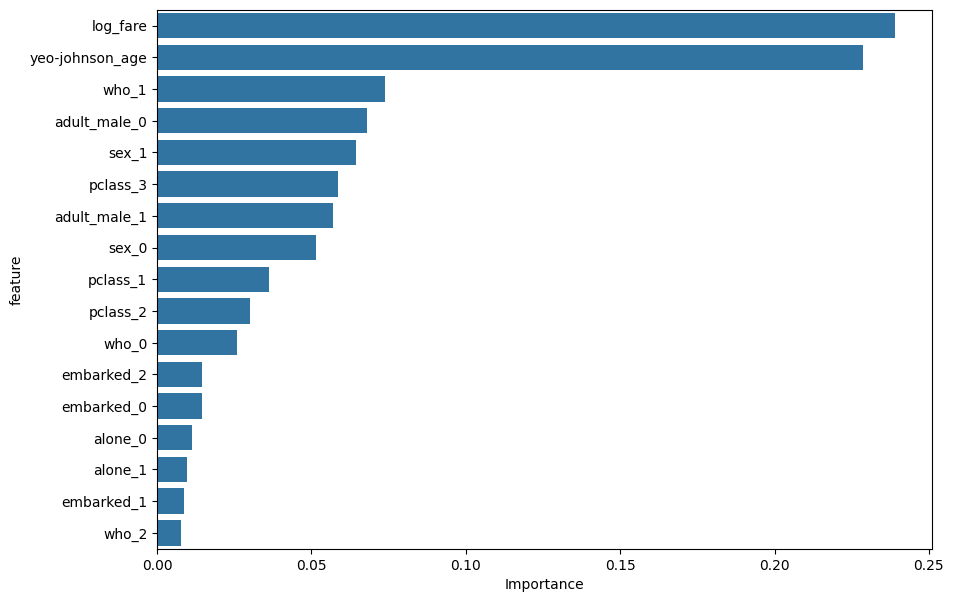

In [70]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

rf_clf.fit(X_trainScaled, y_train)
rf_feature_importances = pd.DataFrame({'feature':X_trainScaled.columns, 'Importance': rf_clf.feature_importances_}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(data=rf_feature_importances, x='Importance', y='feature')
plt.show()

In [71]:
top5train = X_trainScaled[rf_feature_importances['feature'].values[:5]]
top5test = X_testScaled[rf_feature_importances['feature'].values[:5]]

top10train = X_trainScaled[rf_feature_importances['feature'].values[:10]]
top10test = X_testScaled[rf_feature_importances['feature'].values[:10]]

---
### IDEA:

- im going to train and test:
    - a random forest classifier
    - mlp with 1 hidden layer (100 perceptrons)
    - mlp with 3 hidden layers (each 100 perceptrons)
- for each model i will try:
    - the full feature set
    - the top 5 features from the random forests feature_importances_
    - the top 10 features from the random forests feature_importances_

1. Random Forest:
- all features

In [72]:
start_train = time.time()
rf_clf.fit(X_trainScaled, y_train)
end_train = time.time()
train_duration = end_train - start_train

start_preds = time.time()
y_preds = rf_clf.predict(X_testScaled)
end_preds = time.time()
preds_duration = end_preds - start_preds

rf_metrics = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_preds),
    'precision': precision_score(y_test, y_preds, average='macro'),
    'recall': recall_score(y_test, y_preds, average='macro'),
    'train_duration': train_duration,
    'preds_duration': preds_duration},
    index=['RandomForest']
    )

2. Random Forest:
- Top 5 features

In [73]:
start_train = time.time()
rf_clf.fit(top5train, y_train)
end_train = time.time()
train_duration = end_train - start_train

start_preds = time.time()
y_preds = rf_clf.predict(top5test)
end_preds = time.time()
preds_duration = end_preds - start_preds

rf_top5_metrics = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_preds),
    'precision': precision_score(y_test, y_preds, average='macro'),
    'recall': recall_score(y_test, y_preds, average='macro'),
    'train_duration': train_duration,
    'preds_duration': preds_duration},
    index=['RandomForest_Top5']
    )

3. Random Forest:
- top 10 features

In [74]:
start_train = time.time()
rf_clf.fit(top10train, y_train)
end_train = time.time()
train_duration = end_train - start_train

start_preds = time.time()
y_preds = rf_clf.predict(top10test)
end_preds = time.time()
preds_duration = end_preds - start_preds

rf_top10_metrics = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_preds),
    'precision': precision_score(y_test, y_preds, average='macro'),
    'recall': recall_score(y_test, y_preds, average='macro'),
    'train_duration': train_duration,
    'preds_duration': preds_duration},
    index=['RandomForest_Top10']
    )

4. MLP Classifier 1HL:
- all features

In [75]:
mlp_1hl = MLPClassifier(hidden_layer_sizes=(100), max_iter=1000, random_state=42)

start_train = time.time()
mlp_1hl.fit(X_trainScaled, y_train)
end_train = time.time()
train_duration = end_train - start_train

start_preds = time.time()
y_preds = mlp_1hl.predict(X_testScaled)
end_preds = time.time()
preds_duration = end_preds - start_preds

mlp_1hl_full_metrics = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_preds),
    'precision': precision_score(y_test, y_preds, average='macro'),
    'recall': recall_score(y_test, y_preds, average='macro'),
    'train_duration': train_duration,
    'preds_duration': preds_duration},
    index=['MLP_1hl_full']
    )

5. MLP Classifier 1HL:
- top 5 features

In [76]:
start_train = time.time()
mlp_1hl.fit(top5train, y_train)
end_train = time.time()
train_duration = end_train - start_train

start_preds = time.time()
y_preds = mlp_1hl.predict(top5test)
end_preds = time.time()
preds_duration = end_preds - start_preds

mlp_1hl_top5_metrics = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_preds),
    'precision': precision_score(y_test, y_preds, average='macro'),
    'recall': recall_score(y_test, y_preds, average='macro'),
    'train_duration': train_duration,
    'preds_duration': preds_duration},
    index=['MLP_1hl_top5']
    )

6. MLP Classifier 1HL:
- top 10 features

In [77]:
start_train = time.time()
mlp_1hl.fit(top10train, y_train)
end_train = time.time()
train_duration = end_train - start_train

start_preds = time.time()
y_preds = mlp_1hl.predict(top10test)
end_preds = time.time()
preds_duration = end_preds - start_preds

mlp_1hl_top10_metrics = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_preds),
    'precision': precision_score(y_test, y_preds, average='macro'),
    'recall': recall_score(y_test, y_preds, average='macro'),
    'train_duration': train_duration,
    'preds_duration': preds_duration},
    index=['MLP_1hl_top10']
    )

7. MLP Classifier 3HL:
- all features

In [78]:
mlp_3hl = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=1000, random_state=42)

start_train = time.time()
mlp_3hl.fit(X_trainScaled, y_train)
end_train = time.time()
train_duration = end_train - start_train

start_preds = time.time()
y_preds = mlp_3hl.predict(X_testScaled)
end_preds = time.time()
preds_duration = end_preds - start_preds

mlp_3hl_full_metrics = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_preds),
    'precision': precision_score(y_test, y_preds, average='macro'),
    'recall': recall_score(y_test, y_preds, average='macro'),
    'train_duration': train_duration,
    'preds_duration': preds_duration},
    index=['MLP_3hl_full']
    )

8. MLP Classifier 3HL:
- top 5 features

In [79]:
start_train = time.time()
mlp_3hl.fit(top5train, y_train)
end_train = time.time()
train_duration = end_train - start_train

start_preds = time.time()
y_preds = mlp_3hl.predict(top5test)
end_preds = time.time()
preds_duration = end_preds - start_preds

mlp_3hl_top5_metrics = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_preds),
    'precision': precision_score(y_test, y_preds, average='macro'),
    'recall': recall_score(y_test, y_preds, average='macro'),
    'train_duration': train_duration,
    'preds_duration': preds_duration},
    index=['MLP_3hl_top5']
    )

9. MLP Classifier 3HL:
- top 10 features

In [80]:
start_train = time.time()
mlp_3hl.fit(top10train, y_train)
end_train = time.time()
train_duration = end_train - start_train

start_preds = time.time()
y_preds = mlp_3hl.predict(top10test)
end_preds = time.time()
preds_duration = end_preds - start_preds

mlp_3hl_top10_metrics = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_preds),
    'precision': precision_score(y_test, y_preds, average='macro'),
    'recall': recall_score(y_test, y_preds, average='macro'),
    'train_duration': train_duration,
    'preds_duration': preds_duration},
    index=['MLP_3hl_top10']
    )

In [81]:
model_metricsDF = pd.concat([rf_metrics, rf_top5_metrics, rf_top10_metrics,
                             mlp_1hl_full_metrics, mlp_1hl_top5_metrics, mlp_1hl_top10_metrics,
                             mlp_3hl_full_metrics, mlp_3hl_top5_metrics, mlp_3hl_top10_metrics])

model_metricsDF

accuracy  precision    recall  train_duration  \
RandomForest        0.788462   0.784955  0.773098        0.204776   
RandomForest_Top5   0.782051   0.777270  0.767663        0.199011   
RandomForest_Top10  0.794872   0.795207  0.776155        0.195730   
MLP_1hl_full        0.794872   0.822055  0.761889        1.720664   
MLP_1hl_top5        0.769231   0.763547  0.754416        0.460619   
MLP_1hl_top10       0.782051   0.783654  0.760530        0.322606   
MLP_3hl_full        0.756410   0.751071  0.738791        3.501706   
MLP_3hl_top5        0.756410   0.748456  0.745924        2.461617   
MLP_3hl_top10       0.814103   0.815032  0.797215        3.152002   

                    preds_duration  
RandomForest              0.008824  
RandomForest_Top5         0.008163  
RandomForest_Top10        0.009077  
MLP_1hl_full              0.002105  
MLP_1hl_top5              0.002289  
MLP_1hl_top10             0.001563  
MLP_3hl_full              0.002729  
MLP_3hl_top5              0.001705  
MLP_3hl_top10             0.003403

Analysis of training and testing models:

- MLP with 3 hidden layers, each with 100 perceptrons using the top 10 features had the best overall metrics
- MLP with 1 hidden layer using the full feature set had a slightly better precision score
    - training time factor important here as the MLP 3HL model took nearly 2x as long to train and run predictions
- The Random Forest using top 10 features was a lot faster than the MLP 1HL on full set and only improved on the recision but had reduced recall
    - if i had to choose between these 2 i would possibly continue with the random forest over the MLP 1HL model.

Next Steps:
- time factor seems like the biggest consideration here as although there is some variation in metrics they are not enormous gains / losses
- For the sake of learning and seeing what is achievable with hyperparameter tuning i'm going to tune the hyperparameters for the MLP 3HL model using the top 10 feature set.
- If it takes a ridiculously long time, i will look at the 1HL full feature set model.

Metric:
- I'm going to try to maximise accuracy as the model needs to predict equally if a person survives or not.
- Not really a case where it doesnt matter if it gets either case wrong as long as it catches all of one of the classes.
- However, i would like to see what trying to max recall or another metric does to the accuracy average.
---

In [133]:
bestAccuracyScores = {}

---
### Random Forest

Hyperparameter tuning with GridSearch

In [ ]:
rf_params = {
    'n_estimators': [100,200,300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt','log2',None]
    }

rf_clf = RandomForestClassifier(random_state=42)

rf_gSearch = GridSearchCV(rf_clf, rf_params, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

rf_GridSearch = rf_gSearch.best_estimator_
rf_GridSearch.fit(top10train, y_train)

In [134]:
bestAccuracyScores['RandomForest GridSearch'] = rf_gSearch.best_score_

---
### MLP

Hyperparameter tuning with GridSearch

In [82]:
mlp_params = {
    'hidden_layer_sizes': [(100, 100, 100), (50, 100, 50), (200, 100, 50)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001,0.001,0.01],
    'learning_rate': ['constant', 'adaptive']
    }

mlp = MLPClassifier(max_iter=1000, random_state=42)

mlp_gSearch = GridSearchCV(mlp, mlp_params, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

mlp_GridSearch = mlp_gSearch.best_estimator_
mlp_GridSearch.fit(top10train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100, 100, 100), (50, 100, 50),
                                                (200, 100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [135]:
bestAccuracyScores['MLP GridSearch'] = mlp_gSearch.best_score_

---
Hyperparameter tuning with Optuna

In [140]:
import optuna

def objective(trial):

    n_hidden1 = trial.suggest_int('n_hidden1', 25, 200)
    n_hidden2 = trial.suggest_int('n_hidden2', 25, 200)
    n_hidden3 = trial.suggest_int('n_hidden3', 25, 200)

    hidden_layer_sizes = (n_hidden1, n_hidden2, n_hidden3)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
    
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation,
                        solver=solver,
                        alpha=alpha,
                        learning_rate=learning_rate,
                        max_iter=1000)
    
    CV_score = np.mean(cross_val_score(mlp, top10train, y_train, cv=5, scoring='accuracy'))
    return CV_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best accuracy: {study.best_value}")

[I 2024-10-13 18:42:26,250] A new study created in memory with name: no-name-2225d894-2854-4944-832b-8a0685c8b541


[I 2024-10-13 18:42:40,296] Trial 0 finished with value: 0.7804 and parameters: {'n_hidden1': 129, 'n_hidden2': 134, 'n_hidden3': 93, 'activation': 'relu', 'solver': 'adam', 'alpha': 5.542932209369661e-05, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.7804.
[I 2024-10-13 18:43:04,669] Trial 1 finished with value: 0.7948774193548387 and parameters: {'n_hidden1': 160, 'n_hidden2': 197, 'n_hidden3': 155, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0017119232780283043, 'learning_rate': 'constant'}. Best is trial 1 with value: 0.7948774193548387.
[I 2024-10-13 18:43:19,800] Trial 2 finished with value: 0.7868258064516129 and parameters: {'n_hidden1': 88, 'n_hidden2': 194, 'n_hidden3': 109, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.006717680713111731, 'learning_rate': 'constant'}. Best is trial 1 with value: 0.7948774193548387.
[I 2024-10-13 18:43:34,648] Trial 3 finished with value: 0.7628258064516129 and parameters: {'n_hidden1': 191, 'n_hidden2': 152, 'n_hidden

Best hyperparameters: {'n_hidden1': 176, 'n_hidden2': 178, 'n_hidden3': 25, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0003437824365636076, 'learning_rate': 'adaptive'}
Best accuracy: 0.8076774193548388


In [141]:
best_optuna_params = study.best_params
best_optuna_params['hidden_layer_sizes'] = (168,29,63)
n_hiddens = ['n_hidden1', 'n_hidden2', 'n_hidden3']
for _ in n_hiddens:
    best_optuna_params.pop(_)
best_optuna_params

{'activation': 'relu',
 'solver': 'sgd',
 'alpha': 0.0003437824365636076,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (168, 29, 63)}

In [142]:
mlp_optuna = MLPClassifier(**best_optuna_params)
mlp_optuna.fit(top10train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.0003437824365636076, hidden_layer_sizes=(168, 29, 63),
              learning_rate='adaptive', solver='sgd')

In [143]:
bestAccuracyScores['MLP Optuna'] = study.best_value

In [144]:
bestAccuracyScores

{'RandomForest GridSearch': 0.8172774193548389,
 'MLP GridSearch': 0.8077032258064516,
 'MLP Optuna': 0.8076774193548388}

In [147]:
bestScoresDF = pd.DataFrame(bestAccuracyScores.items(), columns=['Model', 'Accuracy Score'])
bestScoresDF

Model  Accuracy Score
0  RandomForest GridSearch        0.817277
1           MLP GridSearch        0.807703
2               MLP Optuna        0.807677

---
## Evaluate

## Random Forest

In [157]:
y_preds = rf_GridSearch.predict(top10test)
print('Classification Report: Random Forest with GridSearch tuned hyperparameters')
print(f'Hyperparameters: {rf_gSearch.best_params_}')
print(classification_report(y_test, y_preds))

Classification Report: Random Forest with GridSearch tuned hyperparameters
Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        92
           1       0.82      0.64      0.72        64

    accuracy                           0.79       156
   macro avg       0.80      0.77      0.78       156
weighted avg       0.80      0.79      0.79       156



Confusion Matrix for Random Forest GridSearch tuned model:


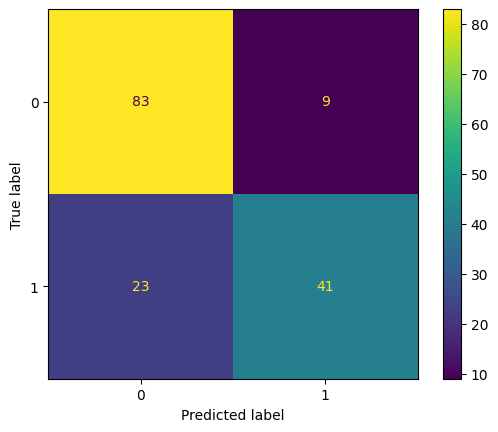

In [156]:
print('Confusion Matrix for Random Forest GridSearch tuned model:')
ConfusionMatrixDisplay.from_estimator(rf_GridSearch, top10test, y_test);

- performed well based on balanced macro avg. precision (0.80) and recall (0.77)
- recall for negative cases (0.90) quite a lot higher than the recall for positive cases (0.64)
- miss-classifying survivors 
- could be due to imbalance in classes
- possibly worth trying to lower the decision threshold, sacrificing some precision for better class 0 recall

## MLP Grid Search

In [158]:
y_preds = mlp_GridSearch.predict(top10test)
print('Classification Report: MLP with GridSearch tuned hyperparameters')
print(f'Hyperparameters: {mlp_gSearch.best_params_}')
print(classification_report(y_test, y_preds))
print('-' * 60)

Classification Report: MLP with GridSearch tuned hyperparameters
Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        92
           1       0.88      0.55      0.67        64

    accuracy                           0.78       156
   macro avg       0.81      0.75      0.75       156
weighted avg       0.80      0.78      0.77       156

------------------------------------------------------------


Confusion Matrix for MLP GridSearch tuned model:


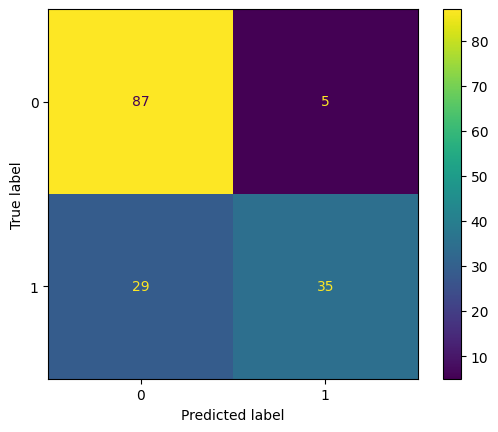

In [153]:
print('Confusion Matrix for MLP GridSearch tuned model:')
ConfusionMatrixDisplay.from_estimator(mlp_GridSearch, top10test, y_test);

- very good recall for class 0 (0.95) but at the cost of quite poor class 1 recall (0.55)
- similarly missing a lot of the survivors (class 1)
- however, precision is high (0.88) for class 1 so when the model predicts a survivor its often correct.
- overall balance between precision and recall could be better and the accuracy is slightly lower than the random forest model

## MLP Optuna

In [159]:
y_preds = mlp_optuna.predict(top10test)
print('Classification Report: MLP with Optuna tuned Hyperparameters')
print(f'Hyperparameters: {best_optuna_params}')
print(classification_report(y_test, y_preds))
print('-' * 60)

Classification Report: MLP with Optuna tuned Hyperparameters
Hyperparameters: {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0003437824365636076, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (168, 29, 63)}
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        92
           1       0.77      0.58      0.66        64

    accuracy                           0.76       156
   macro avg       0.76      0.73      0.74       156
weighted avg       0.76      0.76      0.75       156

------------------------------------------------------------


Confusion Matrix for MLP Optuna tuned model:


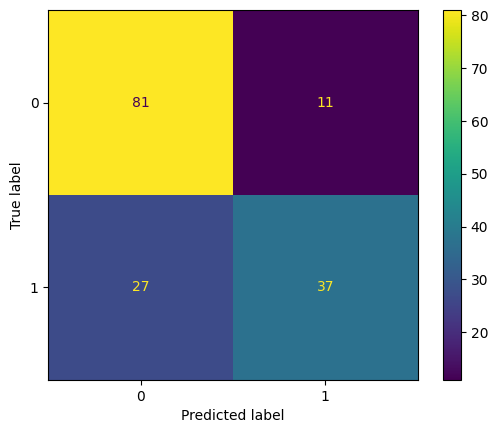

In [154]:
print('Confusion Matrix for MLP Optuna tuned model:')
ConfusionMatrixDisplay.from_estimator(mlp_optuna, top10test, y_test);

- improved balanced precision (0.75 for class 0 and 0.77 for class 1)
- however, both recall and f1 score are slightly lower than RF and GridSearch tuned models
- recall for class 1 is slightly improved compared to GridSearch model
- overall accuracy is lower than both
- macro average shows this model as better balanced, but with lower overall performance

---
### Overall

- Overall, i would go with the random forest:
    - best overall in terms of accuracy (0.79)
    - more balanced performance across both classes compared to the MLP models
    - much faster to train which could be an important factor if this were to used in a project with considerable scaling.